In [1]:
using Pkg

ENV["PYTHON"] = "/home/jboccato/.pyenv/versions/data-env/bin/python3"

Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/8f06b0cfa4c514c7b9546756dbae91fcfbc92dc9/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/Projects/bind_RBM`


In [2]:
using CairoMakie
using RestrictedBoltzmannMachines: sample_from_inputs, inputs_h_from_v, mean_from_inputs
using DelimitedFiles, LinearAlgebra, Statistics, Random
using RestrictedBoltzmannMachines: RBM, Potts, Binary, ReLU, nsReLU, log_pseudolikelihood, initialize!, pcd!,
             sample_v_from_v, free_energy, onehot_encode, sample_h_from_v
using Statistics: mean, cov, std, var, cor
using LinearAlgebra: norm
const ALPHABET = "ACDEFGHIKLMNPQRSTVWY-"
alphabet_dict = Dict(c => i for (i, c) in enumerate(ALPHABET))
split_idx = 81
using JLD2
using MultivariateStats
using MLJ, MLJLinearModels
using Random: MersenneTwister, shuffle, bitrand
using DataFrames
using Logging
using SequenceLogos
using XLSX
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")
using bind_RBM: plot_model_vs_data, create_binding_dictionary_Gogl, create_binding_dictionary, score_strings, parse_rules_file, best_strings_per_class, collect_key_label_hits_per_class, onehot_encode_2d, one_hot_encode,
                plot_matrix_logo, Q_inter, plot_label_matrix
using bind_RBM

In [28]:
using JLD2: @load, @save
function load_final_dict_jld2(path::AbstractString)::Dict{String, Dict{String, Float64}}
    @load path final_dict
    return final_dict
end


D = load_final_dict_jld2("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/Stiffler.jld2")
@show typeof(D)
(k, v) = first(D)
@show k
@show typeof(v)
@show first(collect(keys(v)))  # if v is a Dict
"""
function threshold_transform_binding(
    D::AbstractDict{String, <:AbstractDict{String, <:Real}},
    threshold::Real
)
    out = Dict{String, NamedTuple{(:elements,:labels),Tuple{Vector{String},Vector{Int}}}}()

    for (k, d) in D
        elems = collect(keys(d))
        vals  = [d[e] for e in elems]  # aligned with elems

        newlabs = Vector{Int}(undef, length(vals))
        @inbounds for i in eachindex(vals)
            x = vals[i]
            if x == -1 || x == 0
                newlabs[i] = 0
            elseif x < threshold
                newlabs[i] = 1
            else
                newlabs[i] = 0
            end
        end

        out[k] = (elements = elems, labels = newlabs)
    end

    return out
end
"""
function threshold_transform_binding(
    D::AbstractDict{String, <:AbstractDict{String, <:Real}},
    threshold::Real
)
    out = Dict{String, NamedTuple{(:elements,:labels),Tuple{Vector{String},Vector{Int}}}}()

    for (k, d) in D
        elems = collect(keys(d))
        vals  = [d[e] for e in elems]

        keep_elems = String[]
        keep_labs  = Int[]

        @inbounds for i in eachindex(vals)
            x = vals[i]

            if x == 0
                continue  # remove totally
            elseif x == -1
                push!(keep_elems, elems[i])
                push!(keep_labs, 0)
            elseif x < threshold
                push!(keep_elems, elems[i])
                push!(keep_labs, 1)
            else
                push!(keep_elems, elems[i])
                push!(keep_labs, 0)
            end
        end

        out[k] = (elements = keep_elems, labels = keep_labs)
    end

    return out
end

D_control = threshold_transform_binding(D, 100000.0)

total_ones = sum(sum(nt.labels) for nt in values(D_control))
total = sum(length(nt.labels) for nt in values(D_control))
println("Ones: $total_ones / $total = ", total_ones/total)


typeof(D) = Dict{String, Dict{String, Float64}}
k = "----------GFGIAISGGRDNPETSIVISDVLKGGPAEGQ-LQENDRVAMVNGVSMDNVEHAFAVQQLRKSGKNAKITI-"
typeof(v) = Dict{String, Float64}
first(collect(keys(v))) = "YHHPDQDHWC"
Ones: 702 / 1960 = 0.35816326530612247


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


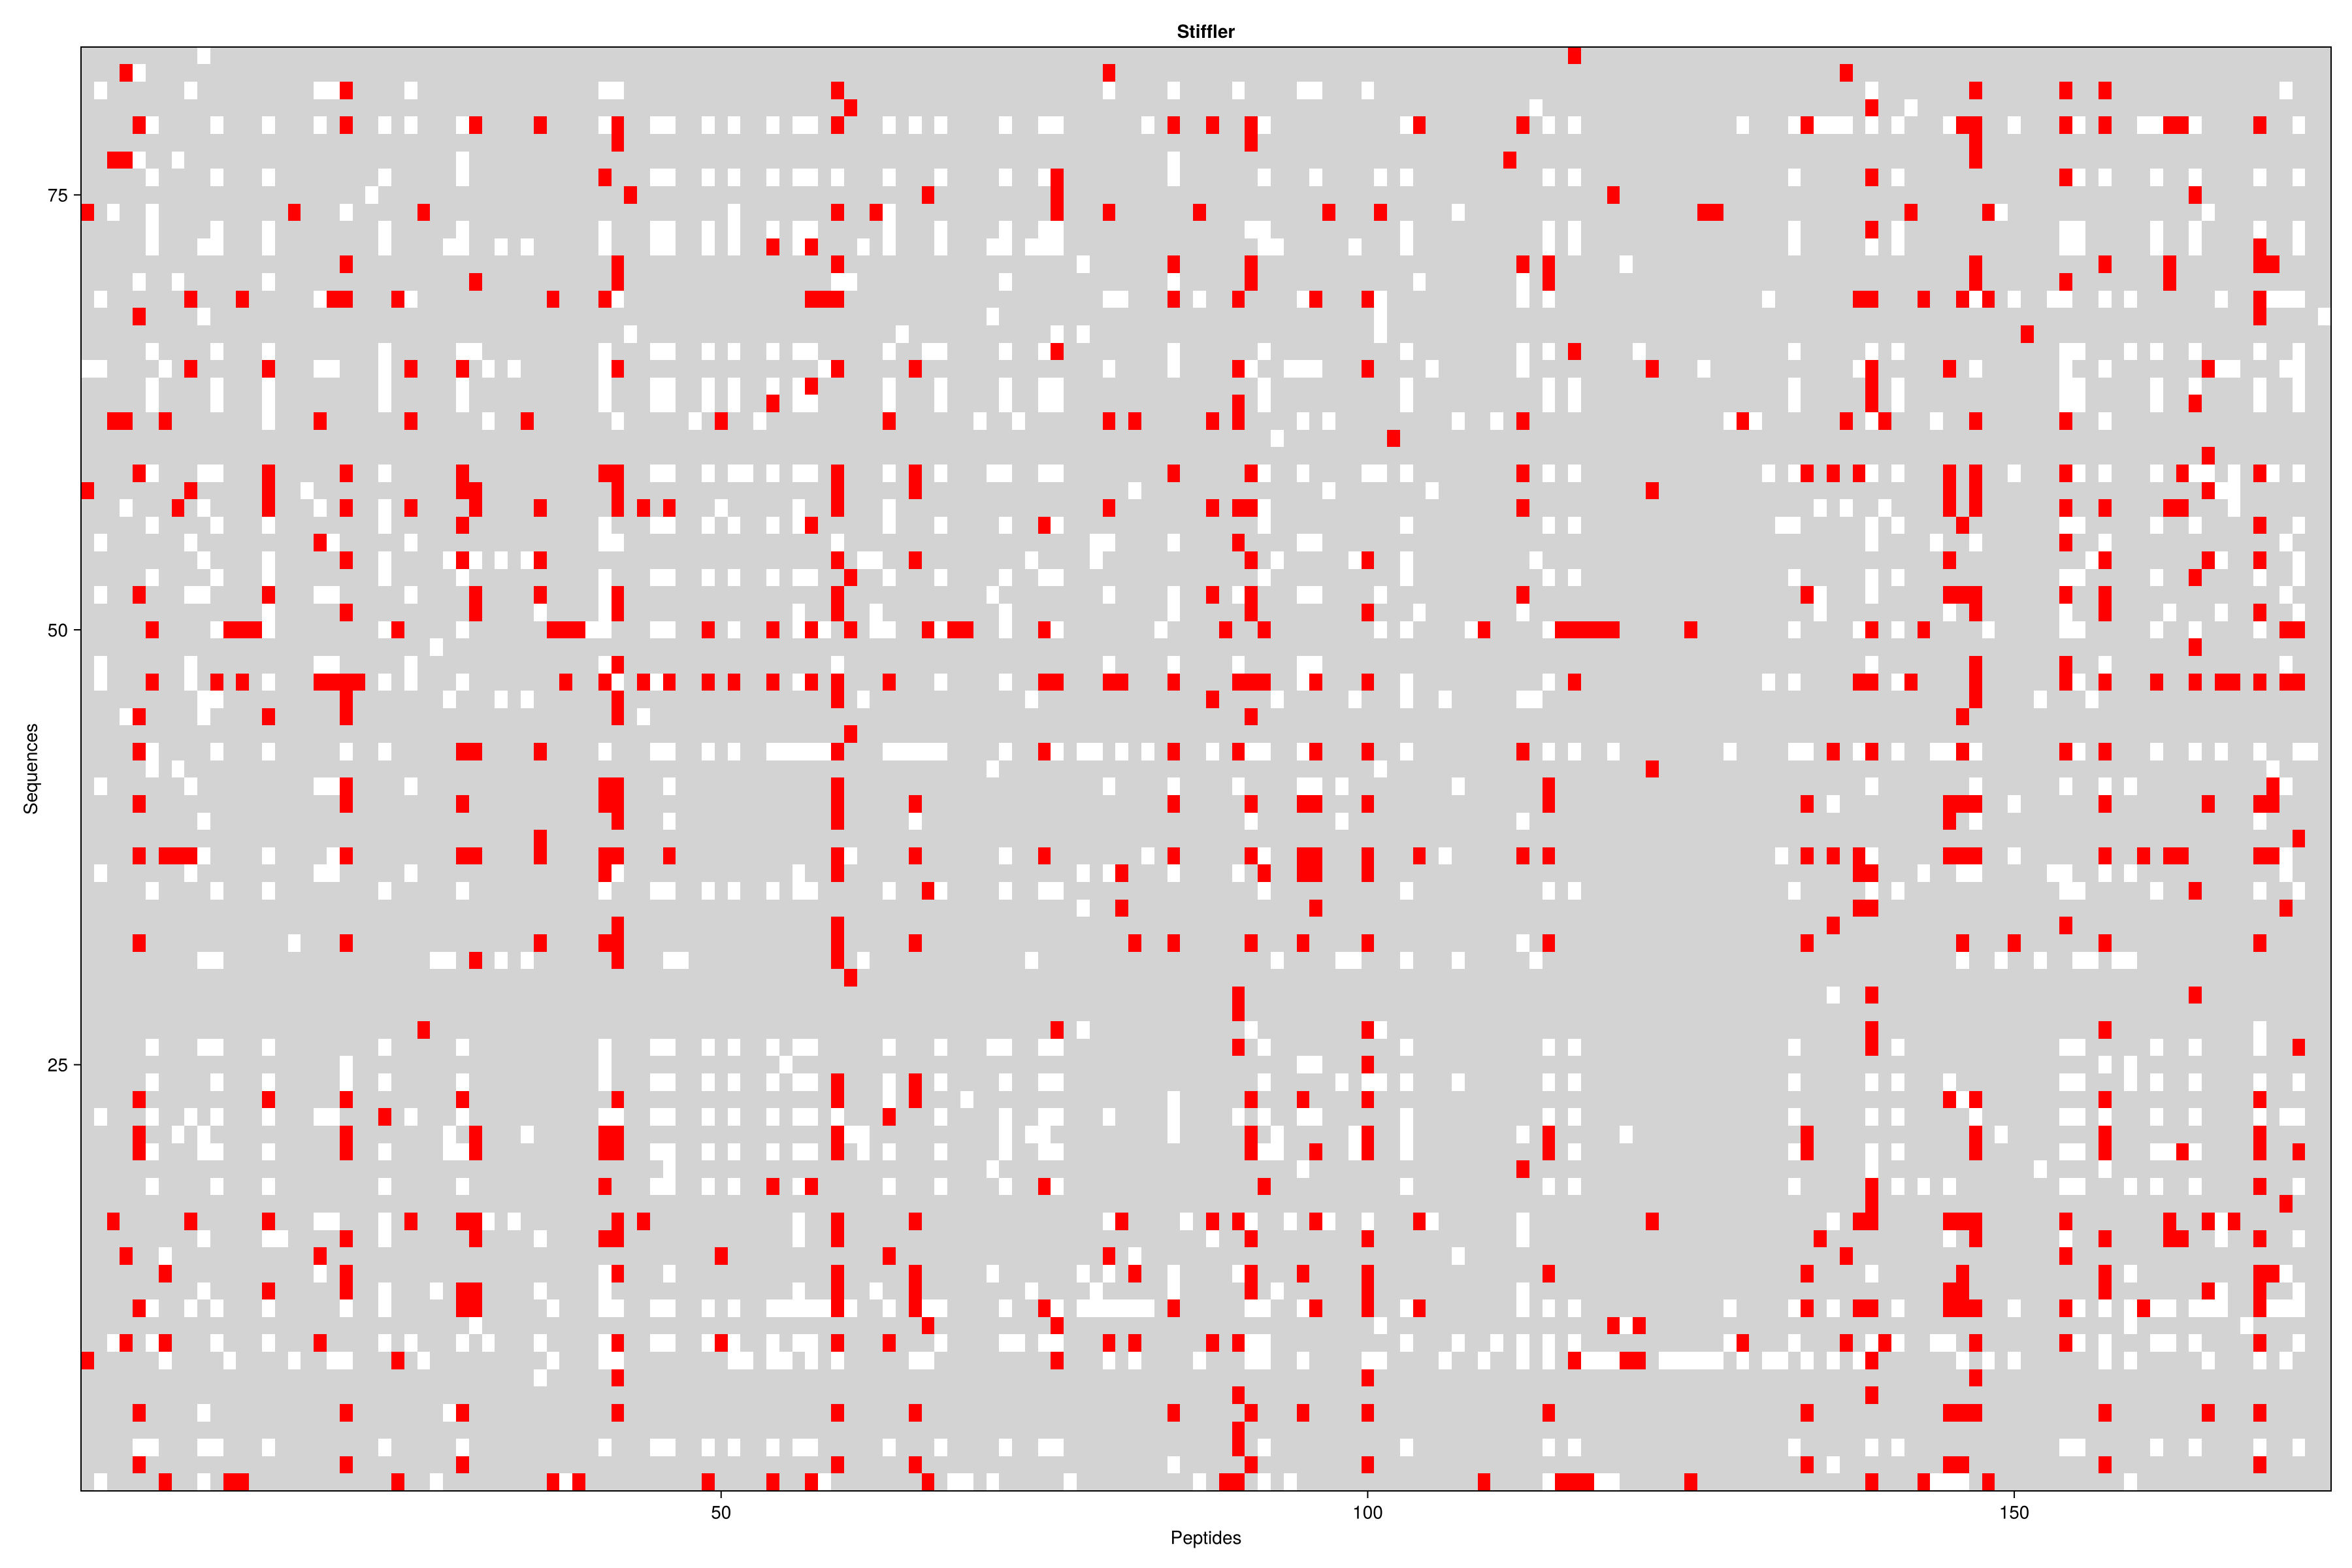

In [29]:
using bind_RBM: plot_label_matrix
plot_label_matrix(D_control, "Stiffler")

In [7]:
data_Gogl = create_binding_dictionary_Gogl("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt")


Skipped rows: 2037


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 84 entries:
  "----------GFGIAISGGRDNP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------SLGLSIAGGVGSP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------PWGFRLQGGKDFN… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------FLGISIVGQSNER… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GFGLTVSG--DN-… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGLSIVGKRSGS… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-----KKDSEGFGFVLRGAKAQT… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSILDYQDPI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VKLFK-NSSGLGFSFSREDNLI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGF

I want to see the performance of the linear classifier on the whole dataset as a function of the L1 regularization

In [4]:
σ(z) = 1 ./ (1 .+ exp.(-z))

# Assume X is (d, N), y is (N,)
# Pack parameters as w = [w₁…w_d; b]  (last entry is bias)
# L1 applies to weights only (not bias) by default.

function neg_loglik(w, X, y; λ::Real=0.0)
    d = size(X, 1)
    @views wb = w[1:d]
    b = w[end]

    z = vec(wb' * X) .+ b          # (N,)
    p = σ(z)
    p = clamp.(p, eps(eltype(p)), 1 - eps(eltype(p)))  # avoid log(0)

    data = -mean(y .* log.(p) .+ (1 .- y) .* log.(1 .- p))
    reg  = λ * sum(abs, wb)        # L1 (weights only)
    return data + reg
end

function neg_loglik_grad!(G, w, X, y; λ::Real=0.0)
    d, N = size(X)
    @views wb = w[1:d]
    b = w[end]

    z = vec(wb' * X) .+ b          # (N,)
    p = σ(z)
    r = p .- y                      # (N,)

    @views G[1:d] .= (X * r) / N .+ λ .* sign.(wb)   # L1 subgradient
    G[end] = mean(r)                                  # bias gradient
    return G
end


neg_loglik_grad! (generic function with 1 method)

In [5]:
using Optim
using Statistics

results = String[]
class_array= Int[]


for (key, value) in data_Gogl
    for (element, label) in zip(value.elements, value.labels)
        if label == 0 || label == 1
            push!(results, key * element)
            push!(class_array, label)
        end
    end
end
full_label = onehot_encode_2d(results, alphabet, alphabet_dict)


1911×68442 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [7]:
d = size(full_label, 1)

# NOTE: if you added a bias as last parameter, w must be length d+1
w0 = 0.01 .* randn(d + 1)

# values to sweep (edit as you like)
λ_grid = 10.0 .^ range(-6, 1; length=12)   # 1e-6 ... 1e1

results = NamedTuple[]
for λ in λ_grid
    res = optimize(
        w -> neg_loglik(w, full_label, class_array; λ=λ),
        (G, w) -> neg_loglik_grad!(G, w, full_label, class_array; λ=λ),
        copy(w0),
        BFGS();
        autodiff = :false
    )

    ŵ = Optim.minimizer(res)

    # predictions (with bias packed as last parameter)
    @views wb = ŵ[1:d]
    b = ŵ[end]
    z = vec(wb' * full_label) .+ b
    p = σ(z)
    ŷ = Int.(p .>= 0.5)
    y_int = Int.(class_array)

    TP = sum((y_int .== 1) .& (ŷ .== 1))
    TN = sum((y_int .== 0) .& (ŷ .== 0))
    FP = sum((y_int .== 0) .& (ŷ .== 1))
    FN = sum((y_int .== 1) .& (ŷ .== 0))

    acc  = (TP + TN) / length(y_int)
    prec = TP / max(TP + FP, 1)
    rec  = TP / max(TP + FN, 1)
    spec = TN / max(TN + FP, 1)
    f1   = 2 * prec * rec / max(prec + rec, 1e-10)
    auc  = compute_auc(y_int, Float32.(p))

    push!(results, (
        λ=λ, acc=acc, prec=prec, rec=rec, spec=spec, f1=f1, auc=auc,
        TP=TP, TN=TN, FP=FP, FN=FN, iters=Optim.iterations(res),
        fmin=Optim.minimum(res), converged=Optim.converged(res)
    ))

    println("λ=$(λ): acc=$(round(acc, digits=4)) f1=$(round(f1, digits=4)) auc=$(round(auc, digits=4)) converged=$(Optim.converged(res))")
end


# optional: pretty print a small table
println("\nλ\t\tacc\tf1\tauc")
for r in results
    println("$(r.λ)\t$(round(r.acc, digits=4))\t$(round(r.f1, digits=4))\t$(round(r.auc, digits=4))")
end


LoadError: UndefVarError: `compute_auc` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [6]:
function unique_elements_from_dict(d::Dict)
    uniq = Set{String}()
    for v in values(d)
        union!(uniq, v.elements)
    end
    return uniq
end

uniq_Gogl     = unique_elements_from_dict(data_Gogl)
uniq_Stiffler = unique_elements_from_dict(data_Stiffler)

common = intersect(uniq_Gogl, uniq_Stiffler)
n_common = length(common)

println("Unique elements in common: ", n_common)

function filter_dict_by_elements(d::Dict, common_elements::Set{String})
    out = Dict{eltype(keys(d)), eltype(values(d))}()

    for (k, v) in d
        filtered = [e for e in v.elements if e in common_elements]

        if !isempty(filtered)
            # reconstruct named tuple, replacing only `elements`
            out[k] = merge(v, (elements = filtered,))
        end
    end

    return out
end


filtered_Gogl     = filter_dict_by_elements(data_Gogl, common)
filtered_Stiffler = filter_dict_by_elements(data_Stiffler, common)

union_dict = merge(filtered_Gogl, filtered_Stiffler)
union_tot = merge(data_Gogl, data_Stiffler)

Unique elements in common: 53


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 338 entries:
  "-------GPAPWGFRLQGGKDFN… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLEK-MSAGLGFSLEGGKGSL… => (elements = ["SKSLERATQL", "LLQEEWETVM", "THREVK…
  "-----------------------… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "-VELTK-NVQGLGITIAGYIGDK… => (elements = ["SSIDLWETAL", "STLTIFETAL", "DTLEKF…
  "-------DGGPLGIHVVPFSARG… => (elements = ["EPTTTTSVPL", "SSEGVPDLLV", "DTLEKF…
  "-----TVSGNGLGIRIVGGKEIP… => (elements = ["RSLEEEESQL", "EMDRRPATVV", "DPRNTQ…
  "-------KNPGLGFSISGGISGQ… => (elements = ["HYPASPDSWV", "QYPGSPDSWV", "PLPPEE…
  "-IELEK-GSKGLGFSILDYQDPI… => (elements = ["SVISRREWYV", "QKNKDREYYV", "GDSSRK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLKRDPHRGFGFVINEGEYSG… => (elements = ["LHLHGTGIQV", "SVISRREWYV", "DSATVR…
  "-VVLTADPVTGFG

In [7]:
# Or flatten into a single vector of all elements
all_elements_flat = vcat([value.elements for value in values(union_dict)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_common = score_strings(file_content, all_elements_flat)


Dict{String, Vector{Float64}} with 53 entries:
  "RSSGGDDFWF" => [0.0, 0.2, 0.2, 0.666667, 0.75, 1.0, 0.166667, 0.4, 0.166667,…
  "DSEEELPTRL" => [0.0, 0.0, 0.2, 0.166667, 0.25, 0.25, 0.166667, 0.0, 0.5, 0.6…
  "PDSNPEESSV" => [0.4, 0.2, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.2,…
  "EFKQTSSFLV" => [0.2, 0.4, 0.4, 0.5, 0.75, 0.5, 0.333333, 0.0, 0.166667, 0.0,…
  "SRPRPDDLEI" => [0.0, 0.0, 0.4, 0.5, 0.5, 0.75, 0.166667, 0.0, 0.166667, 0.0,…
  "NKSEPFLTWL" => [0.0, 0.0, 0.2, 0.333333, 0.75, 0.5, 0.5, 0.6, 0.333333, 0.6,…
  "KPDKQEEFYA" => [0.0, 0.2, 0.2, 0.5, 0.5, 0.75, 0.0, 0.0, 0.166667, 0.2, 0.33…
  "RQKEVRESKC" => [0.6, 0.0, 0.0, 0.333333, 0.0, 0.25, 0.0, 0.0, 0.5, 0.4, 0.33…
  "KKNKDKEYYV" => [0.4, 0.2, 0.4, 0.666667, 0.75, 1.0, 0.166667, 0.0, 0.5, 0.2,…
  "ASGLDKRDYV" => [0.4, 0.2, 0.2, 0.5, 0.5, 0.5, 0.333333, 0.0, 0.333333, 0.0, …
  "AHGSTRDQSI" => [0.2, 0.0, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.0,…
  "DTKNYKQTSV" => [0.6, 0.2, 0.2, 0.333333, 0.25, 0.25, 0.1666

In [9]:
using CairoMakie

function plot_histograms(results)
    all_scores = collect(values(results))
    n_classes = length(all_scores[1])
    
    fig = CairoMakie.Figure(resolution = (1200, 1000))
    
    for i in 1:n_classes
        row = div(i - 1, 4) + 1
        col = mod(i - 1, 4) + 1
        
        class_scores = [scores[i] for scores in all_scores]
        
        ax = Axis(fig[row, col], xlabel = "Score", ylabel = "Count", title = "CLASS $i")
        hist!(ax, class_scores, bins = 20, color = (:blue, 0.5))
    end
    
    fig
end

plot_histograms (generic function with 1 method)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


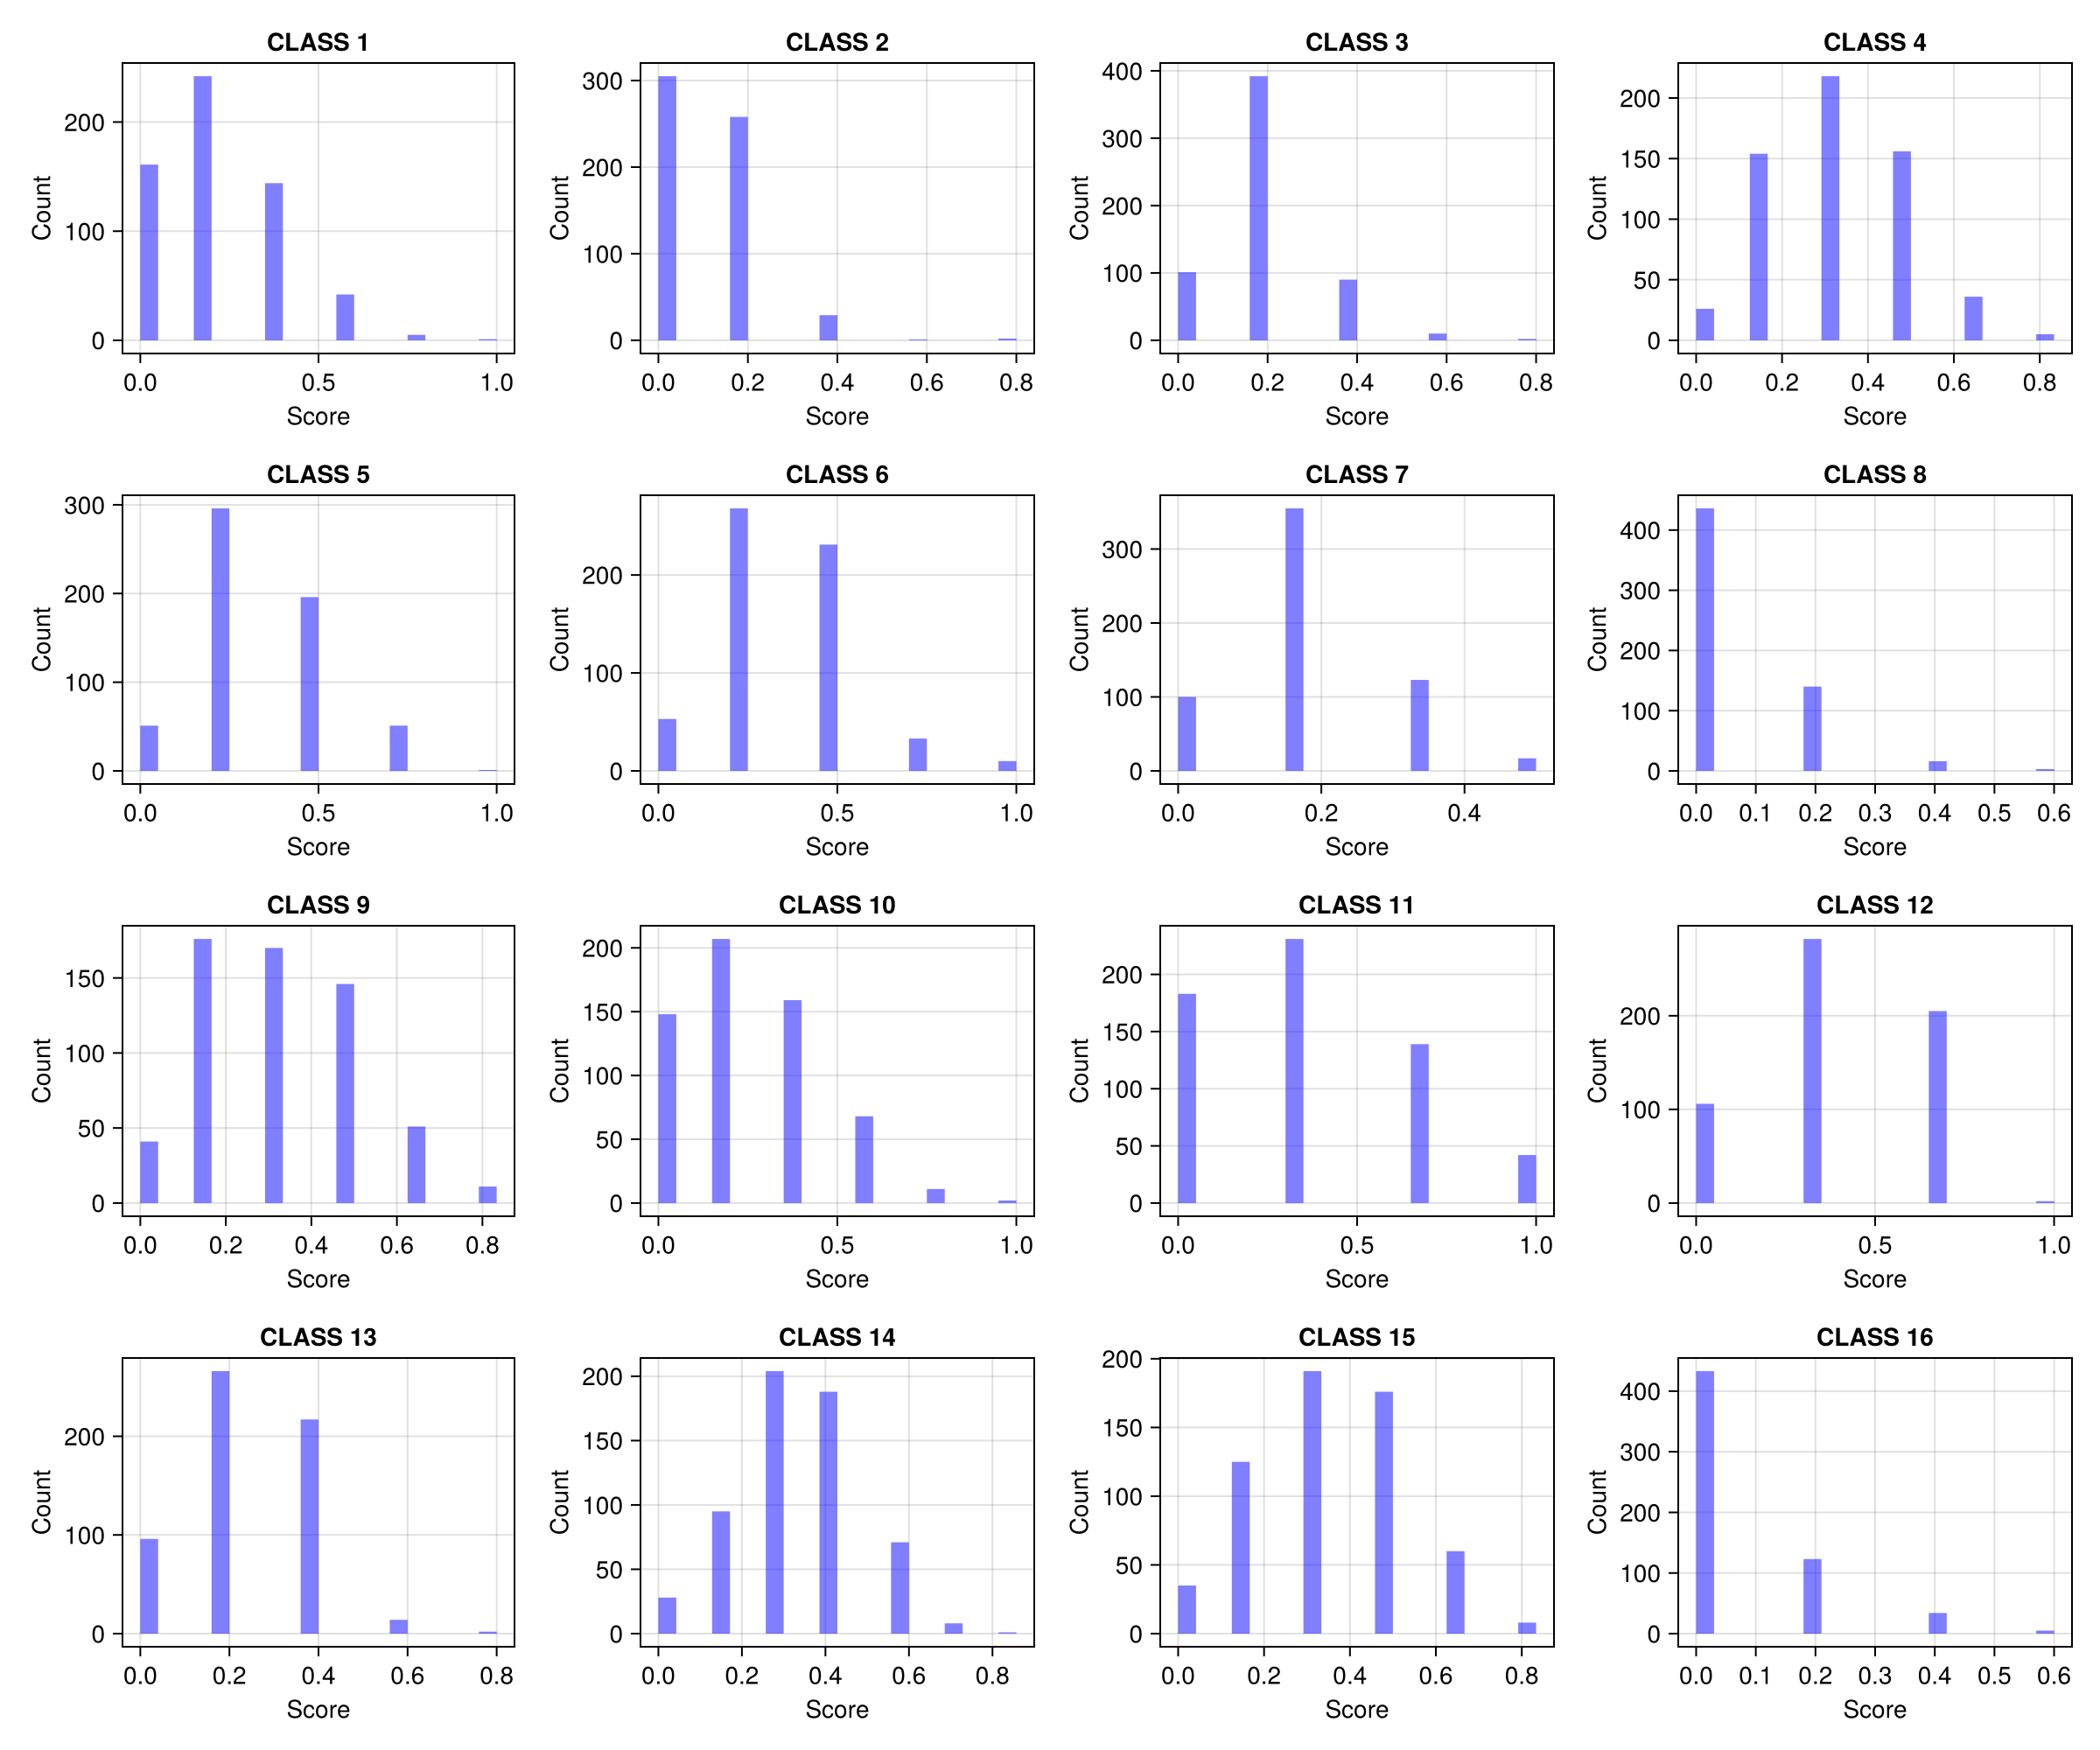

In [11]:
# Or flatten into a single vector of all elements
all_elements_union = vcat([value.elements for value in values(union_tot)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_full = score_strings(file_content, all_elements_union)
plot_histograms(peptides_full)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


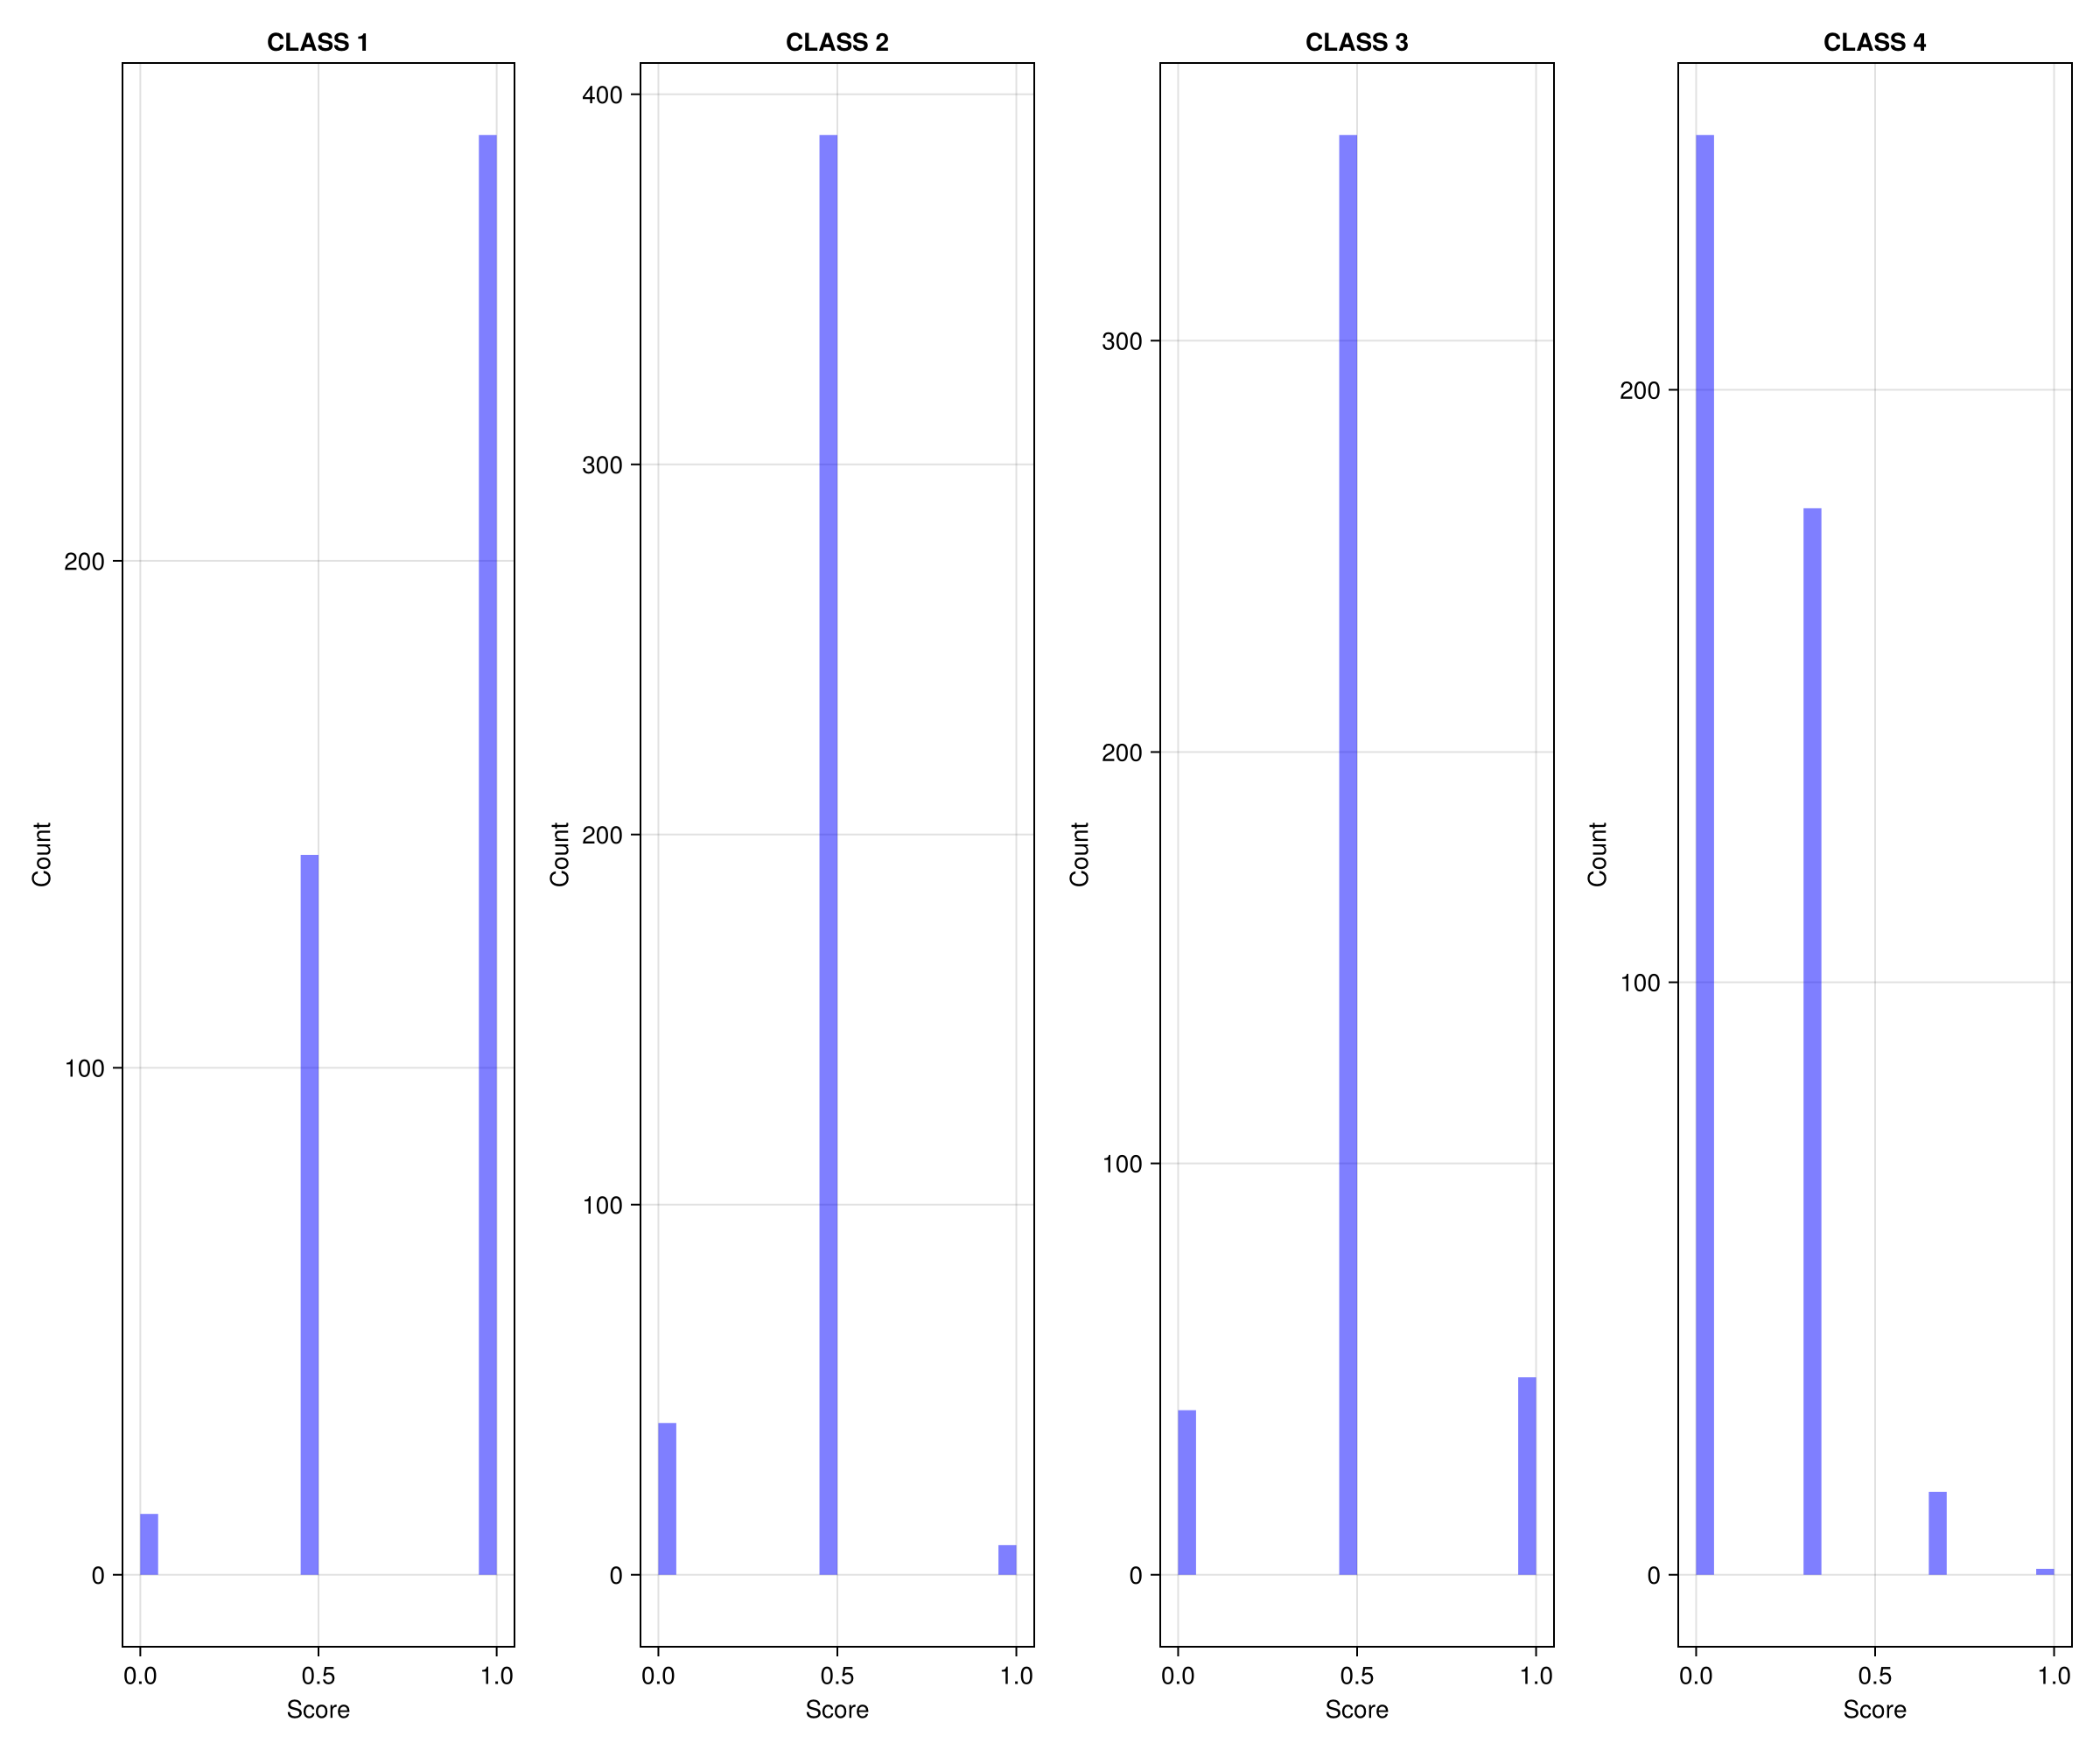

In [10]:
# Or flatten into a single vector of all elements
all_elements_Gogl = vcat([value.elements for value in values(data_Gogl)]...)
file_content_reduced = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides4.txt", String)

peptides_full = score_strings(file_content_reduced, all_elements_Gogl)
plot_histograms(peptides_full)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


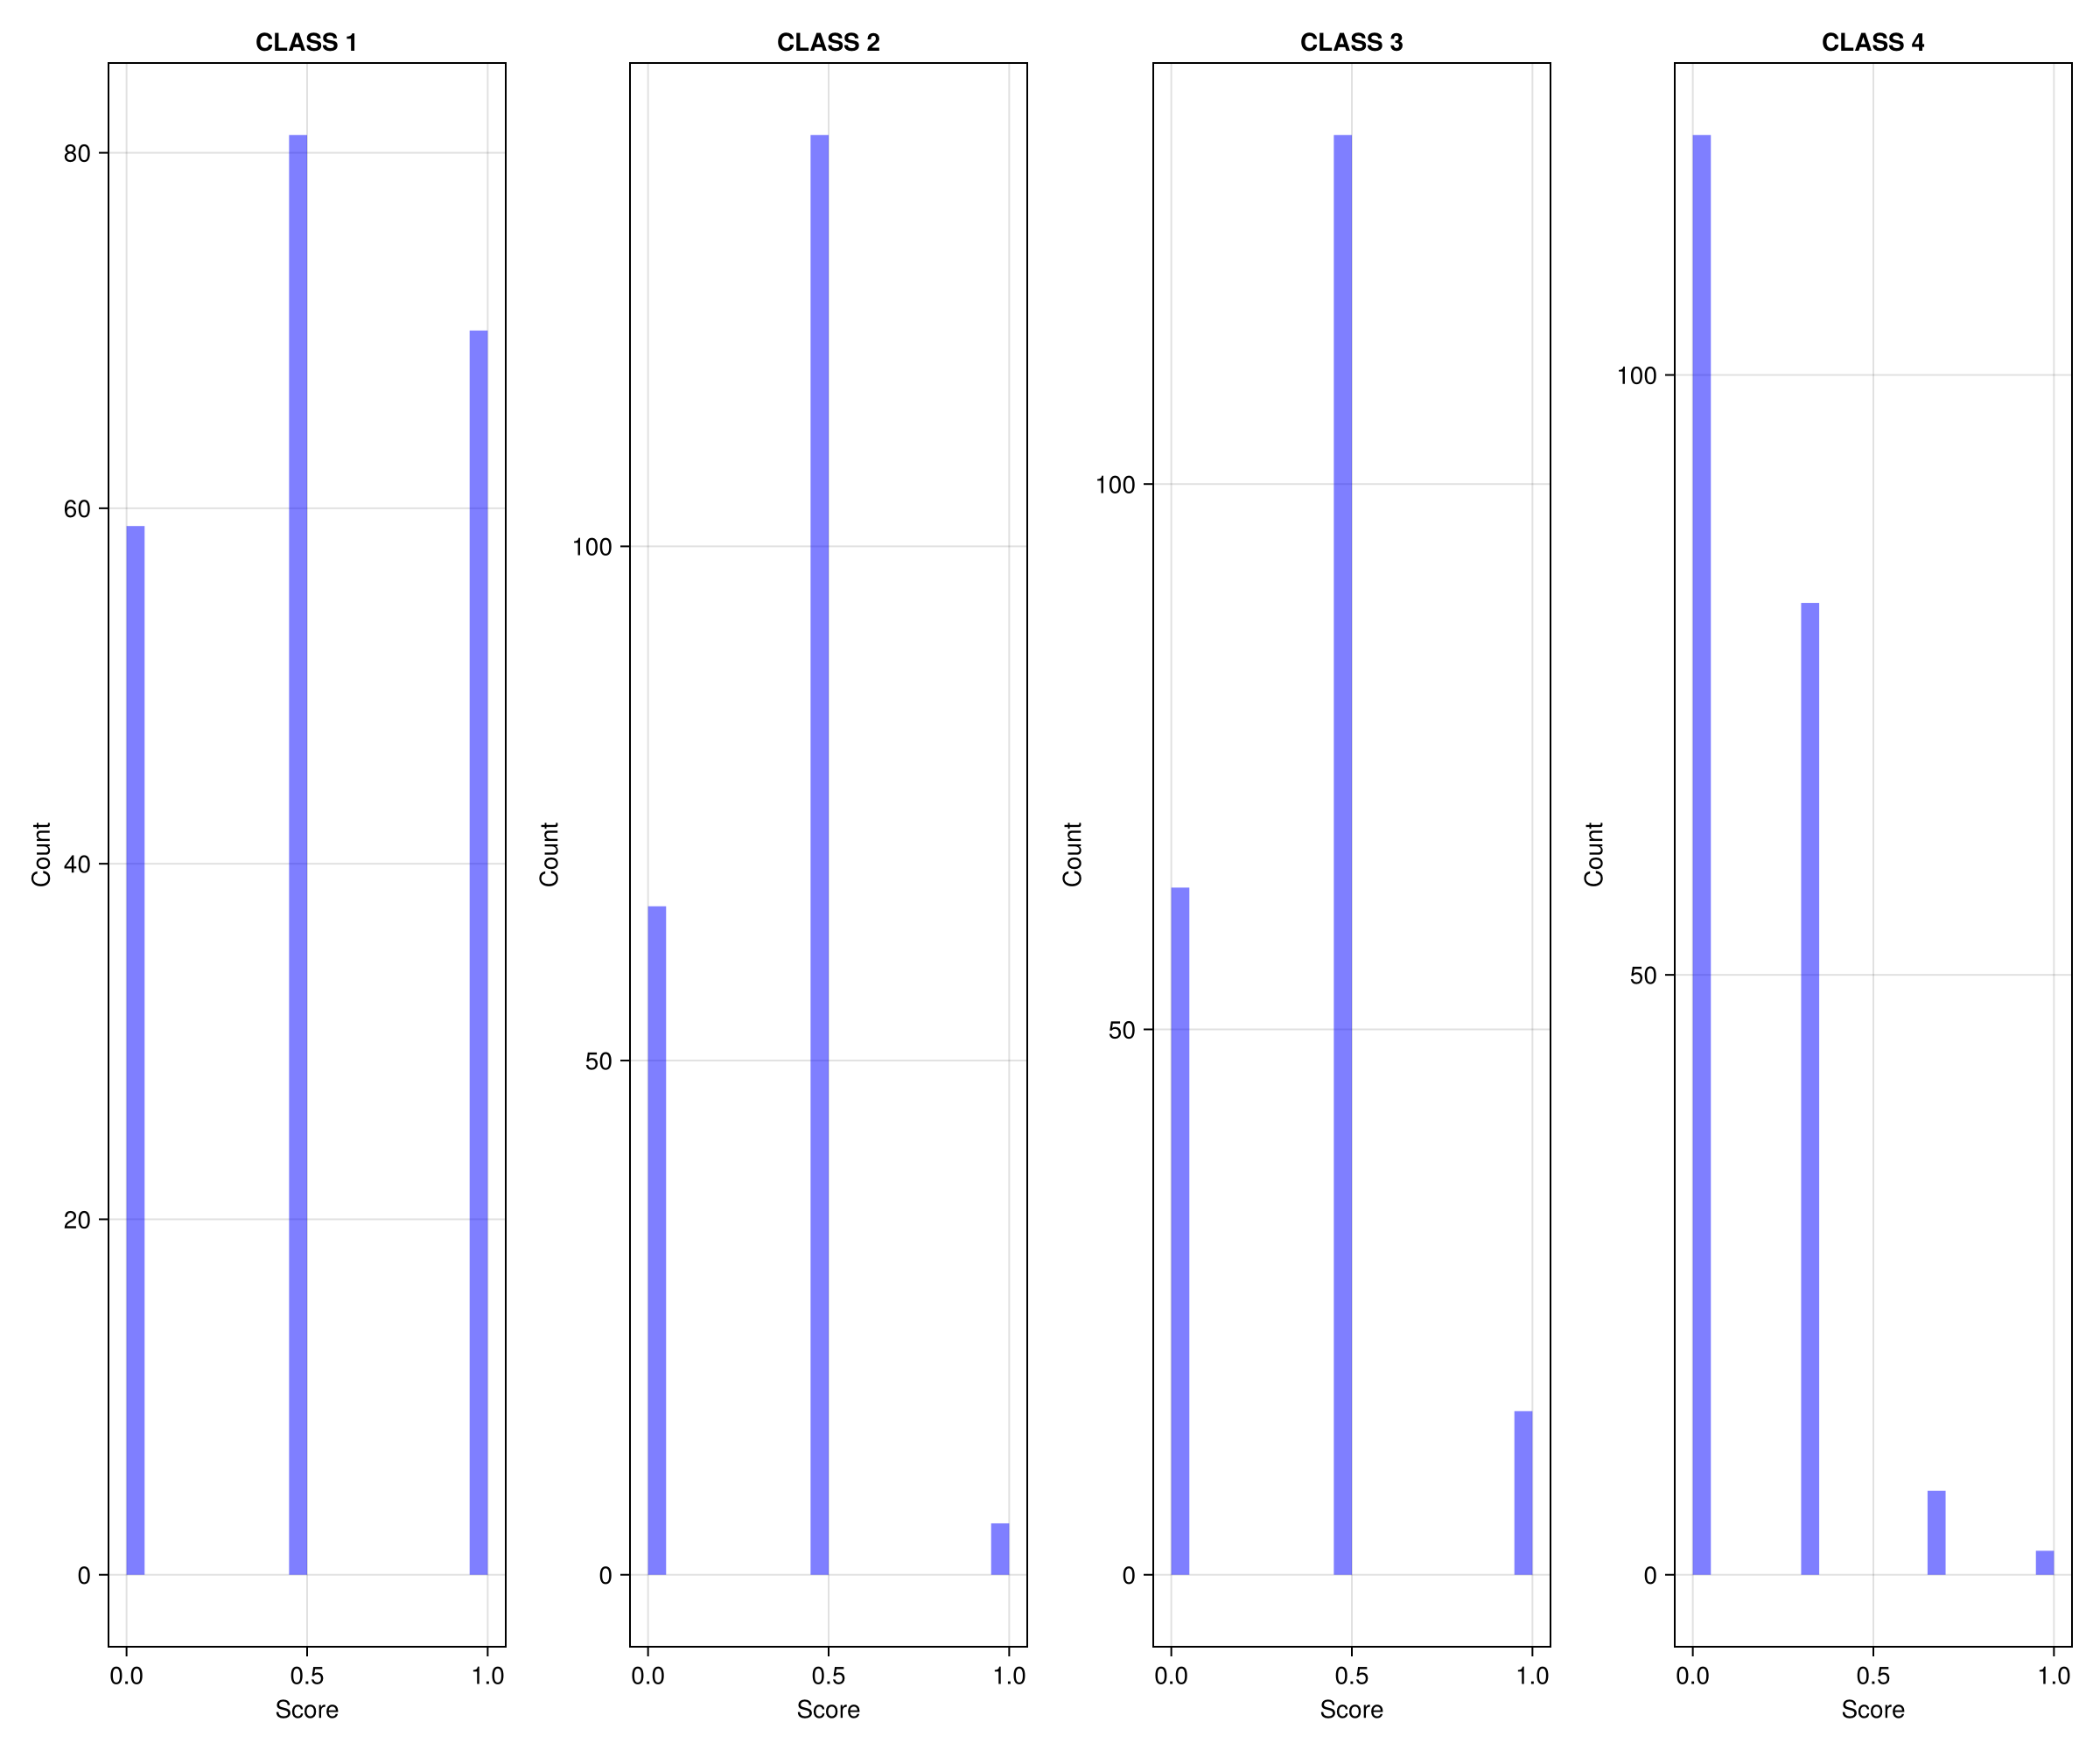

In [11]:
# Or flatten into a single vector of all elements
all_elements_Stiffler = vcat([value.elements for value in values(data_Stiffler)]...)
file_content_reduced = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides4.txt", String)

peptides_full = score_strings(file_content_reduced, all_elements_Stiffler)
plot_histograms(peptides_full)

In [12]:
dict = best_strings_per_class(file_content_reduced, all_elements_Gogl)
indexed_4, by_class_4 = collect_key_label_hits_per_class(dict, data_Gogl)


((class_names = ["#CLASS 1", "#CLASS 2", "#CLASS 3", "#CLASS 4"], class_to_idx = Dict("#CLASS 1" => 1, "#CLASS 3" => 3, "#CLASS 4" => 4, "#CLASS 2" => 2), keys_by_class = [["-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMT

In [13]:
using Statistics
using SequenceLogos
using PyCall
pyimport("matplotlib").use("module://matplotlib_inline.backend_inline")

using PyPlot


function weights_to_logo_matrix(w::AbstractVector, A::Int)
    D = length(w)
    @assert D % A == 0 "length(w) must be a multiple of alphabet size A"
    L = D ÷ A
    return reshape(Float64.(w), A, L)  # (A, L)
end

function plot_model_weight_logo(model::NamedTuple,
                                alphabet::AbstractVector;
                                center::Bool = true,
                                figsize::Tuple{Real,Real} = (12,4),
                                colorscheme::Symbol = :aminoacid,
                                custom_colors::Dict{Char,Any} = Dict{Char,Any}(),
                                title_str::AbstractString = "",
                                kwargs...)

    @assert get(model, :status, :no_status) == :ok "Model not trained (status != :ok)"
    w = model.w
    A = length(alphabet)
    M = weights_to_logo_matrix(w, A)

    if center
        M = M .- mean(M; dims=1)
    end

    fig = plot_matrix_logo(M, alphabet;
                           figsize=figsize,
                           colorscheme=colorscheme,
                           custom_colors=custom_colors,
                           kwargs...)
    if !isempty(title_str)
        PyPlot.title(title_str)
    end
    return fig
end

"""
Non-blocking: returns Dict(class_name => fig)
Also includes a safety check for very long sequences (max_positions).
"""
function plot_all_weight_logos(models_by_class::Dict{String,<:Any},
                               alphabet::AbstractVector;
                               center::Bool = true,
                               figsize::Tuple{Real,Real} = (12,4),
                               colorscheme::Symbol = :aminoacid,
                               custom_colors::Dict{Char,Any} = Dict{Char,Any}(),
                               max_positions::Int = 200,
                               max_classes::Int = typemax(Int),
                               display_each::Bool = true)

    figs = Dict{String, Any}()
    class_names = sort(collect(keys(models_by_class)))
    class_names = class_names[1:min(end, max_classes)]

    for (i, cname) in enumerate(class_names)
        @info "Rendering logo $i/$(length(class_names)): $cname"
        m = models_by_class[cname]
        if !(m isa NamedTuple) || get(m, :status, :no_status) != :ok
            continue
        end

        L = length(m.w) ÷ length(alphabet)
        if L > max_positions
            @warn "Skipping $cname: logo length $L > max_positions=$max_positions"
            continue
        end

        fig = plot_model_weight_logo(m, alphabet;
                                     center=center,
                                     figsize=figsize,
                                     colorscheme=colorscheme,
                                     custom_colors=custom_colors,
                                     title_str="Weights logo: $cname/4")
        figs[cname] = fig
        if display_each
            display(fig)
        end
    end

    return figs
end


plot_all_weight_logos

OKAY THIS APPROACH APPEARS TO HAVE SOME DISATVANTAGES, FIRST OF ALL THAT WE ARE UTILIZING ONLY A FRACTION OF OUR PEPTIDES. I WILL TRY TO UTILIZE THE 4 CLASS DEFINITION WE WERE LOOKING AT BEFORE

In [13]:
data_Gogl = create_binding_dictionary_Gogl("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt")

Skipped rows: 2037


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 84 entries:
  "----------GFGIAISGGRDNP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------SLGLSIAGGVGSP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------PWGFRLQGGKDFN… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------FLGISIVGQSNER… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GFGLTVSG--DN-… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGLSIVGKRSGS… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-----KKDSEGFGFVLRGAKAQT… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSILDYQDPI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VKLFK-NSSGLGFSFSREDNLI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGF

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


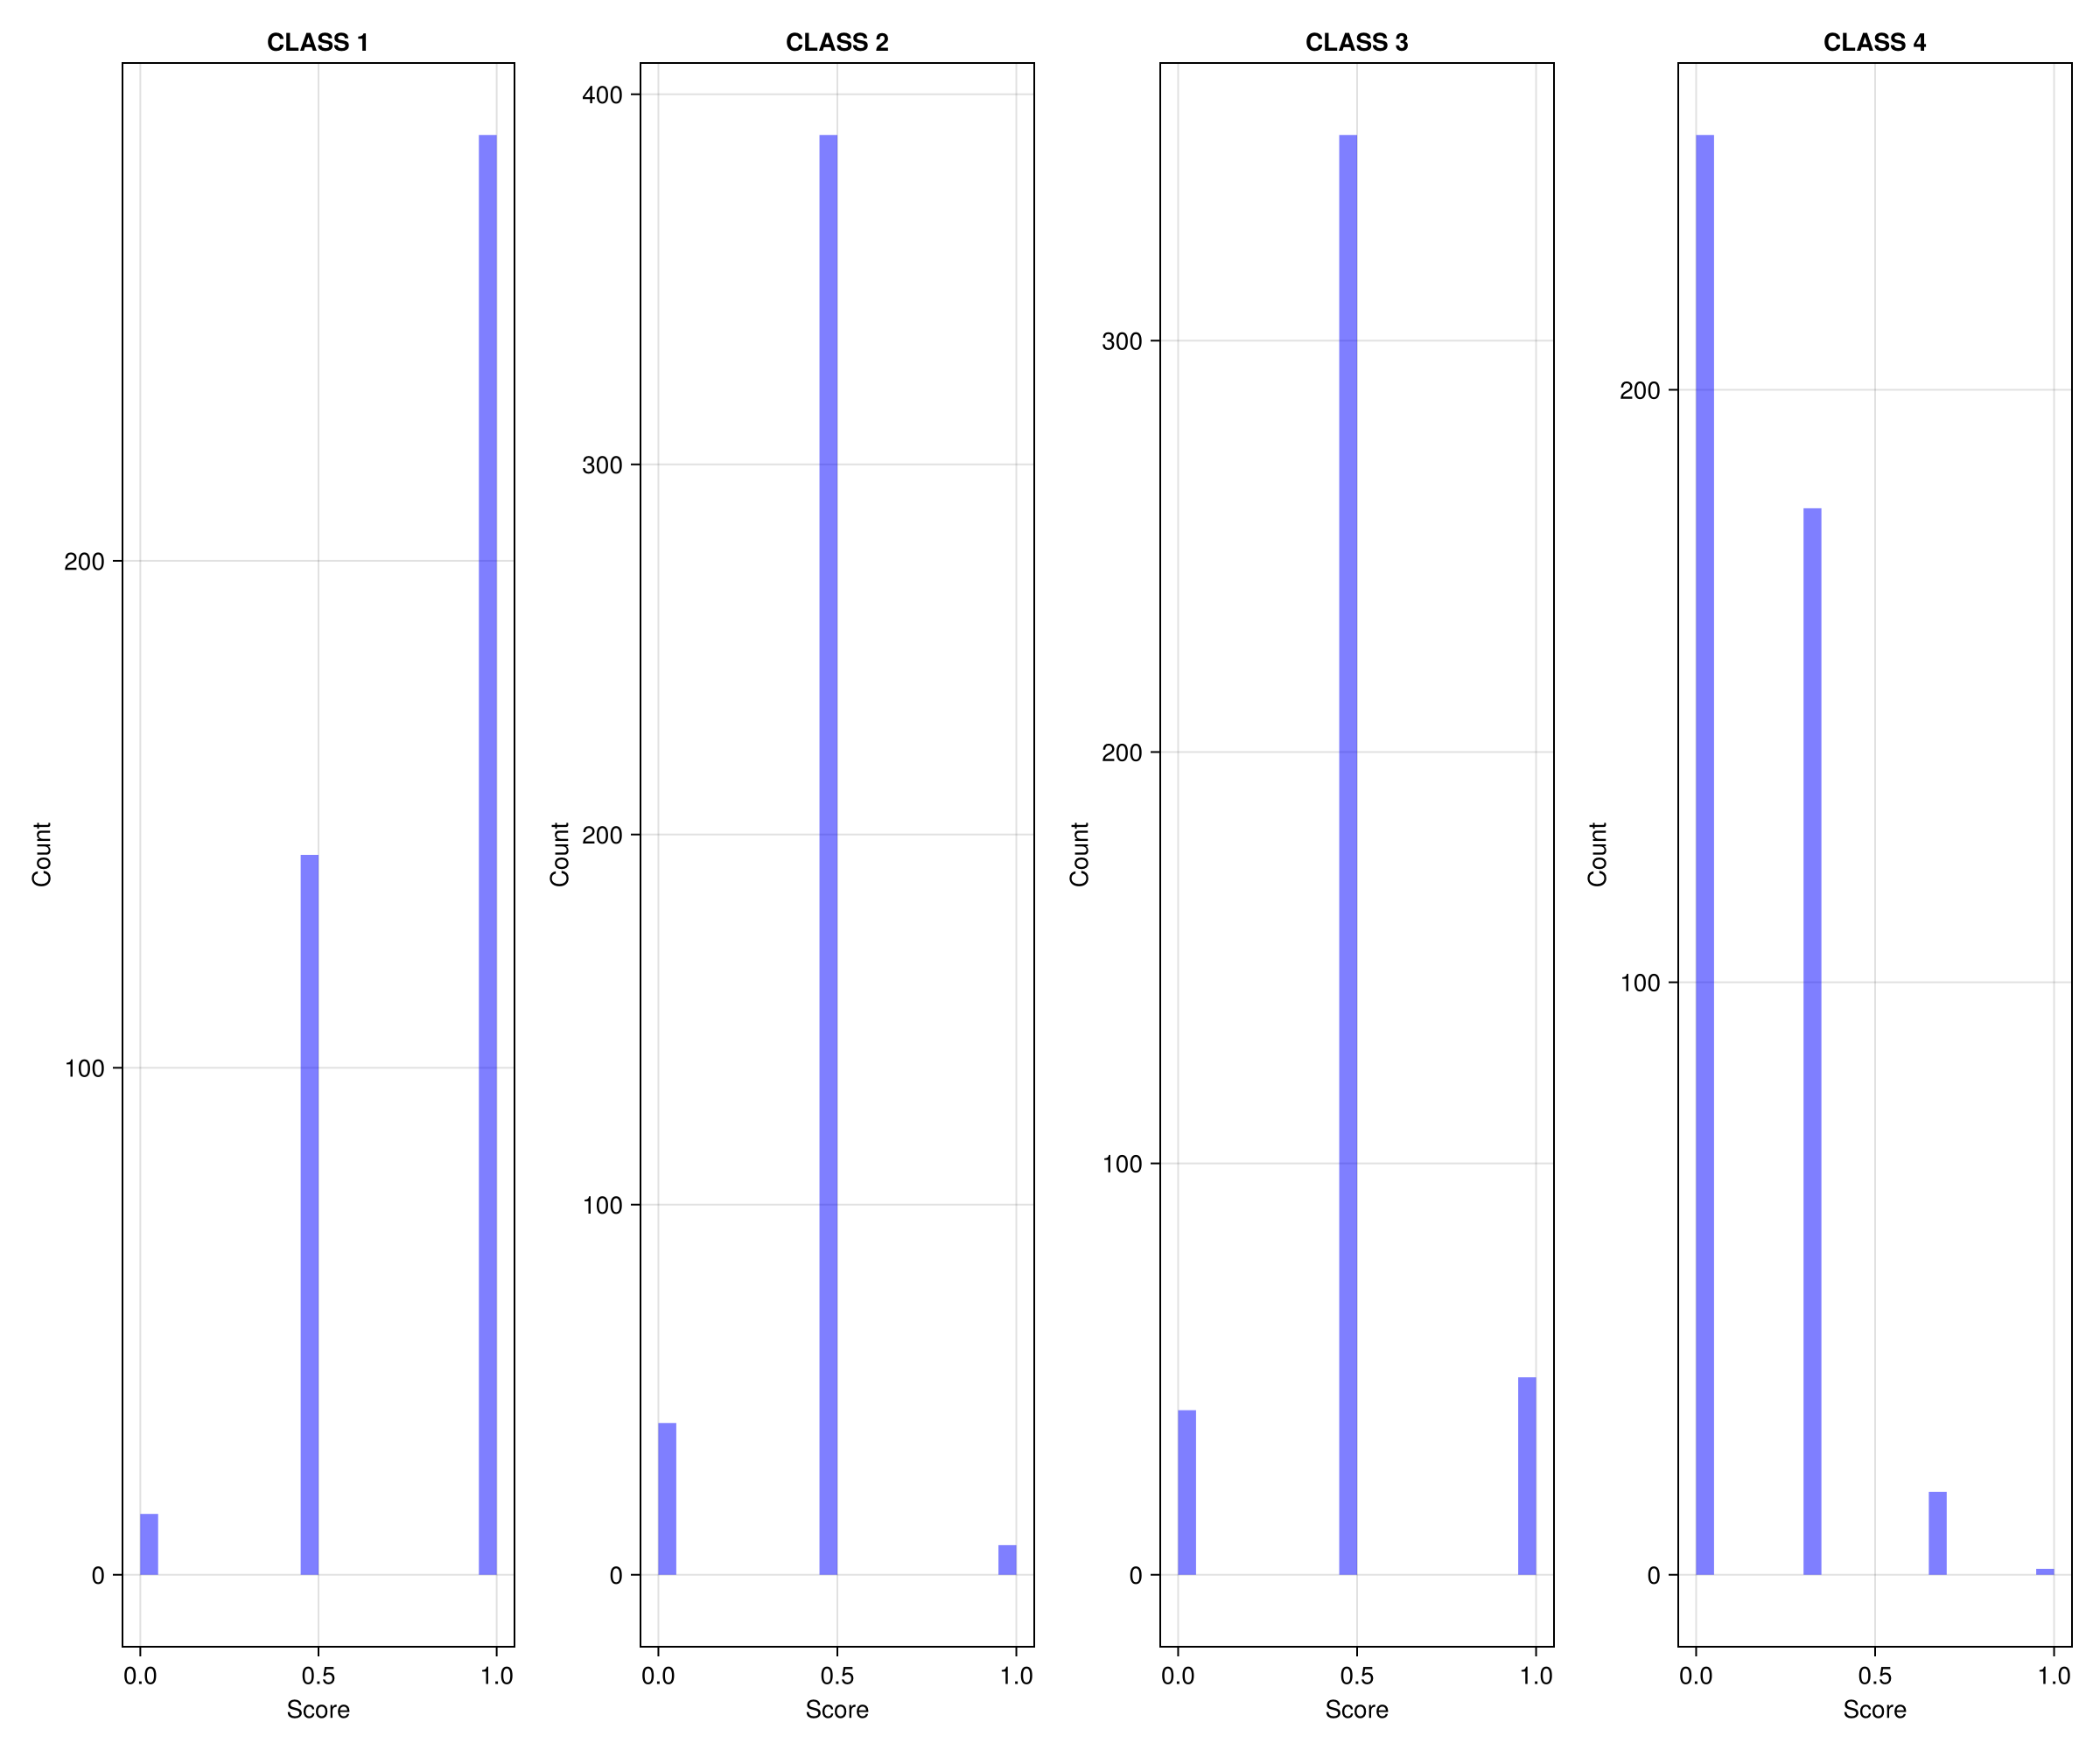

In [14]:
# Or flatten into a single vector of all elements
all_elements_Gogl = vcat([value.elements for value in values(data_Gogl)]...)
file_content_reduced = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides4.txt", String)

peptides_full = score_strings(file_content_reduced, all_elements_Gogl)
plot_histograms(peptides_full)

In [15]:
dict = best_strings_per_class(file_content_reduced, all_elements_Gogl)
indexed_4, by_class_4 = collect_key_label_hits_per_class(dict, data_Gogl)

((class_names = ["#CLASS 1", "#CLASS 2", "#CLASS 3", "#CLASS 4"], class_to_idx = Dict("#CLASS 1" => 1, "#CLASS 3" => 3, "#CLASS 4" => 4, "#CLASS 2" => 2), keys_by_class = [["-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMTHLEAQNKIKGCTGSLNMTLQ", "-------GPAPWGFRLQGGKDFN-MPLTISSLKDGKAAQAN-VRIGDVVLSIDGINAQGMT

In [13]:
results = String[]
class_array= Int[]

for (key, value) in data_Gogl
    for (element, label) in zip(value.elements, value.labels)
        if label == 0 || label == 1
            push!(results, key * element)
            push!(class_array, label)
        end
    end
end
full_label = one_hot_encode(results, alphabet, alphabet_dict)   
y = vec(Float32.(class_array))
println("full_label size: ", size(full_label))
keep = [1:81; 88:size(full_label,2)]
B = full_label[:, keep, :]
println("B size: ", size(B))

full_label size: (21, 91, 68442)
B size: (21, 85, 68442)


In [14]:
using bind_RBM: Q_inter_centered
Q_reduced_center_4 = Q_inter_centered(B, split_idx, class_array)

1701×84 Matrix{Float32}:
  0.0          0.0          0.0          …   0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
 -1.69403f-5   1.07863f-5  -9.65952f-5      -2.4378f-6   0.0  -7.66445f-6
  0.0          0.0          0.0              0.0         0.0   0.0
  0.0          0.0          0.0          …   0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
  0.0          0.0          0.0          …   0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
  0.0          0.0          0.0              0.0         0.0   0.0
  ⋮                                      ⋱                    
 -8.14949f-6   1.97617f-6   4.2412

In [15]:
F = svd(Q_reduced_center_4)          # factorization object
U = F.U
S = F.S            # vector of singular values
V = F.V            # note: A ≈ U * Diagonal(S) * V'

84×84 adjoint(::Matrix{Float32}) with eltype Float32:
 -0.0181338    0.012505    -0.0433305   …   0.0           0.0
  0.0121096   -0.0187249   -0.0614496      -5.7666f-14    2.14043f-6
 -0.100397     0.0297863    0.119324        8.03618f-14  -1.64476f-6
  0.439097    -0.135776     0.759961        5.53987f-14  -1.68758f-6
 -0.0132762   -0.00602898  -0.0196068       1.63355f-13   5.07925f-6
 -0.00697565   0.0299623   -0.0199284   …   1.87001f-14  -2.88907f-6
 -0.00599355   0.00770458  -0.0424594       1.09298f-13  -6.41503f-6
  0.00664256  -0.0171019   -0.105369       -2.21503f-14  -1.71436f-7
 -0.0500937    0.0155303   -0.0239503       1.22054f-13  -1.0507f-6
 -0.0296925   -0.0210514   -0.056726        8.60566f-14   6.56379f-7
 -0.0129804    0.0268864   -0.0053171   …  -1.11088f-13  -2.06337f-6
 -0.0155969    0.0305906    0.0113862      -1.92363f-13  -3.23521f-7
 -0.0487615    0.0557006   -0.0110813       1.31951f-13   6.11095f-8
  ⋮                                     ⋱                

In [35]:
keep_last4(it) = [last(s, min(4, lastindex(s))) for s in it]
els = sort!(collect(uniq_Gogl))     # Vector{String} (sorted = deterministic)

ending = keep_last4(els)
onehot_end = onehot_encode_2d(ending, alphabet, alphabet_dict)
project = V[1:10,:]*onehot_end

10×438 Matrix{Float32}:
  0.00681727   0.0144186  -0.0954991  …   0.435665    -0.0393748  -0.0281599
 -0.195846     0.0922208   0.224026       0.247018     0.218539   -0.152233
  0.0807107   -0.0333978  -0.106071      -0.0992593    0.359485   -0.368333
 -0.157028     0.0484757  -0.0592596      0.00483492  -0.135907    0.0753453
  0.158142     0.0213549   0.0287071      0.0436242    0.185153    0.0285971
  0.227174     0.373675   -0.152565   …  -0.149634     0.273829   -0.182234
 -0.246014    -0.391343   -0.138017      -0.284407    -0.41604     0.079658
 -0.0314646    0.0495223  -0.0834233      0.203138    -0.0595983   0.142082
  0.080022     0.477924    0.191492       0.287863    -0.114511    0.168382
  0.251633    -0.210203    0.0709046     -0.141487     0.0768291  -0.0274044

In [14]:
using LinearAlgebra
using PyCall

"""
    save_sequence_logo_first_n(W::AbstractMatrix, A::Int, L::Int, n::Int; kwargs...)

Plot the first `n` columns of `W` as sequence logos, assuming each column is a
flattened (A×L) weight matrix stored in column-major order (Julia default).

- `W` is (A*L) × K  (K components)
- Each logo uses `reshape(W[:,k], A, L)` and then calls `save_sequence_logo`.

Returns a vector of filenames.
"""

py"""
import numpy as np
import matplotlib.pyplot as plt
import logomaker
import pandas as pd

def plot_sequence_logo(mat_LxA, alphabet,
                       title=None, xlabel="Position", ylabel=None,
                       center_values=False,
                       stack_order="big_on_top",
                       color_scheme="classic",
                       figsize=(32,6),
                       filename=None, dpi=200, show=True):

    df = pd.DataFrame(mat_LxA, columns=list(alphabet))

    plt.figure(figsize=figsize)
    logomaker.Logo(
        df,
        center_values=center_values,
        stack_order=stack_order,
        color_scheme=color_scheme
    )

    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return filename
"""
plot_sequence_logo = py"plot_sequence_logo"

const PROTEIN_ALPHABET_STR = [string(c) for c in collect(ALPHABET)]
function save_sequence_logo_first_n(W::AbstractMatrix, A::Int, L::Int, n::Int;
    prefix::AbstractString = "sequence_logo",
    # pass-through kwargs to save_sequence_logo:
    alphabet_str::Vector{String} = PROTEIN_ALPHABET_STR,
    mode::Symbol = :weight,
    center_values::Bool = true,
    stack_order::AbstractString = "big_on_top",
    color_scheme::AbstractString = "classic",
    figsize = (32, 6),
    ylabel::AbstractString = "Weight",
    dpi::Int = 200,
    show::Bool = false
)
    @assert size(W, 1) == A * L "Expected size(W,1) == A*L, got $(size(W,1)) vs $(A*L)"
    K = size(W, 2)
    n_use = min(n, K)

    files = String[]
    for k in 1:n_use
        P = reshape(W[:, k], A, L)  # A×L (alphabet×position)
        fn = "$(prefix)_$(k).png"
        save_sequence_logo(P;
            alphabet_str=alphabet_str,
            mode=mode,
            center_values=center_values,
            stack_order=stack_order,
            color_scheme=color_scheme,
            figsize=figsize,
            title="Component $(k)",
            ylabel=ylabel,
            filename=fn,
            dpi=dpi,
            show=show
        )
        push!(files, fn)
    end
    return files
end

function save_sequence_logo(P::AbstractMatrix;
    alphabet_str::Vector{String} = PROTEIN_ALPHABET_STR,
    mode::Symbol = :weight,                 # PCA weights typically
    center_values::Bool = true,             # <- matches your snippet
    stack_order::AbstractString = "big_on_top",
    color_scheme::AbstractString = "classic",
    figsize = (32, 6),
    title = nothing,
    ylabel = "Weight",
    filename::Union{Nothing,String} = "sequence_logo.png",
    dpi::Int = 200,
    show::Bool = false
)
    A, L = size(P)
    @assert length(alphabet_str) == A "alphabet length must equal rows in P (A=$A)"

    # Prepare matrix for logomaker: L x A
    mat_LxA =
        mode == :weight ? permutedims(Array{Float64}(P)) :
        permutedims(Array{Float64}(P))  # keep simple; add your prob/count logic if needed

    mat_np = numpy.array(mat_LxA)

    plot_sequence_logo(
        mat_np, alphabet_str,
        title, "Position", ylabel,
        center_values,
        stack_order,
        color_scheme,
        figsize,
        filename,
        dpi,
        show
    )

    return filename
end

save_sequence_logo (generic function with 1 method)

In [ ]:
files = save_sequence_logo_first_n(V, 21, 4, 5; prefix="pc_logo", show=false)

/home/jboccato/.pyenv/versions/data-env/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '-' is not in color_dict. Using black.
  warnings.warn(str(Error))
/home/jboccato/.pyenv/versions/data-env/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'D' is not in color_dict. Using black.
  warnings.warn(str(Error))
/home/jboccato/.pyenv/versions/data-env/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'E' is not in color_dict. Using black.
  warnings.warn(str(Error))
/home/jboccato/.pyenv/versions/data-env/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'F' is not in color_dict. Using black.
  warnings.warn(str(Error))
/home/jboccato/.pyenv/versions/data-env/lib/python3.12/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'H' is not in color_dict. Using black.
  w

5-element Vector{String}:
 "pc_logo_1.png"
 "pc_logo_2.png"
 "pc_logo_3.png"
 "pc_logo_4.png"
 "pc_logo_5.png"

In [15]:
using PyCall
using LinearAlgebra  # optional, but fine to keep around

# --- Python imports via PyCall ---
np  = pyimport("numpy")
pd  = pyimport("pandas")
plt = pyimport("matplotlib.pyplot")
logomaker = pyimport("logomaker")

# (Optional but recommended in headless/server environments)
# This avoids GUI backend issues when saving figures.
pyimport("matplotlib").use("Agg")

# --- Define the Python-side plotting function (Logomaker) ---
py"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

# Amino-acid color scheme (Logomaker-compatible):
# groups by physicochemical class (common "protein" style)
_AA_COLORS = {
    'A': "orange", 'V': "orange", 'L': "orange", 'I': "orange", 'M': "orange",
    'F': "green",  'Y': "green",  'W': "green",
    'H': "cyan",   'K': "cyan",   'R': "cyan",
    'D': "red",    'E': "red",
    'S': "purple", 'T': "purple", 'N': "purple", 'Q': "purple",
    'C': "pink",   'G': "gray",   'P': "magenta",
    '-': "black"
}

def _plot_sequence_logo(mat_LxA, alphabet,
                        title=None, xlabel="Position", ylabel="Weight",
                        center_values=True,
                        stack_order="big_on_top",
                        color_scheme="aminoacid",
                        figsize=(32,6),
                        filename=None, dpi=200, show=False):
    '''
    mat_LxA: numpy array shape (L, A) [positions x alphabet]
    alphabet: list of strings length A
    '''
    mat = np.asarray(mat_LxA, dtype=float)
    if mat.ndim != 2:
        raise ValueError(f"mat_LxA must be 2D, got shape {mat.shape}")

    L, A = mat.shape
    if len(alphabet) != A:
        raise ValueError(f"alphabet length {len(alphabet)} != A {A}")

    df = pd.DataFrame(mat, columns=list(alphabet))

    plt.figure(figsize=figsize)

    # Default amino-acid scheme: if user passes "aminoacid", use our dict.
    # Otherwise pass through to Logomaker's built-in schemes / user dict.
    cs = _AA_COLORS if (isinstance(color_scheme, str) and color_scheme.lower() == "aminoacid") else color_scheme

    logomaker.Logo(
        df,
        center_values=center_values,
        stack_order=stack_order,
        color_scheme=cs
    )

    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return filename
"""
_plot_sequence_logo = py"_plot_sequence_logo"

# --- Julia wrapper: P is A×L (alphabet × position), like your reshape(W[:,k], A, L) ---
function save_sequence_logo(P::AbstractMatrix;
    alphabet_str::Vector{String},
    title = nothing,
    ylabel::AbstractString = "Weight",
    center_values::Bool = true,
    stack_order::AbstractString = "big_on_top",
    color_scheme::AbstractString = "aminoacid",
    figsize = (32, 6),
    filename::Union{Nothing,String} = "sequence_logo.png",
    dpi::Int = 200,
    show::Bool = false
)
    A, L = size(P)
    @assert length(alphabet_str) == A "alphabet_str length must equal rows in P (A=$A)"

    # Logomaker expects L×A (positions × alphabet)
    mat_LxA = permutedims(Array{Float64}(P))  # L×A
    mat_np  = np.array(mat_LxA)

    _plot_sequence_logo(
        mat_np,
        alphabet_str;
        title=title,
        xlabel="Position",
        ylabel=ylabel,
        center_values=center_values,
        stack_order=stack_order,
        color_scheme=color_scheme,
        figsize=figsize,
        filename=filename,
        dpi=dpi,
        show=show
    )

    return filename
end

# --- Julia wrapper: w is flat length A*L (no bias) ---
# This matches the common Julia layout where you do reshape(w, A, L)
function save_sequence_logo_from_w(w::AbstractVector, A::Int, L::Int;
    alphabet_str::Vector{String},
    title = nothing,
    ylabel::AbstractString = "Weight",
    center_values::Bool = true,
    stack_order::AbstractString = "big_on_top",
    color_scheme::AbstractString = "aminoacid",
    figsize = (32, 6),
    filename::Union{Nothing,String} = "sequence_logo.png",
    dpi::Int = 200,
    show::Bool = false
)
    @assert length(w) == A*L "Expected length(w) == A*L ($(A*L)), got $(length(w))"
    P = reshape(Array{Float64}(w), A, L)  # A×L (alphabet×position) in Julia
    return save_sequence_logo(P;
        alphabet_str=alphabet_str,
        title=title,
        ylabel=ylabel,
        center_values=center_values,
        stack_order=stack_order,
        color_scheme=color_scheme,
        figsize=figsize,
        filename=filename,
        dpi=dpi,
        show=show
    )
end

# --- Batch helper: W is (A*L)×K, save first n components as logos ---
function save_sequence_logo_first_n(W::AbstractMatrix, A::Int, L::Int, n::Int;
    prefix::AbstractString = "sequence_logo",
    alphabet_str::Vector{String},
    center_values::Bool = true,
    stack_order::AbstractString = "big_on_top",
    color_scheme::AbstractString = "aminoacid",
    figsize = (32, 6),
    ylabel::AbstractString = "Weight",
    dpi::Int = 200,
    show::Bool = false
)
    @assert size(W, 1) == A*L "Expected size(W,1) == A*L ($(A*L)), got $(size(W,1))"
    K = size(W, 2)
    n_use = min(n, K)

    files = String[]
    for k in 1:n_use
        w = @view W[:, k]
        fn = "$(prefix)_$(k).png"
        save_sequence_logo_from_w(w, A, L;
            alphabet_str=alphabet_str,
            title="Component $(k)",
            ylabel=ylabel,
            center_values=center_values,
            stack_order=stack_order,
            color_scheme=color_scheme,
            figsize=figsize,
            filename=fn,
            dpi=dpi,
            show=show
        )
        push!(files, fn)
    end
    return files
end


save_sequence_logo_first_n (generic function with 1 method)

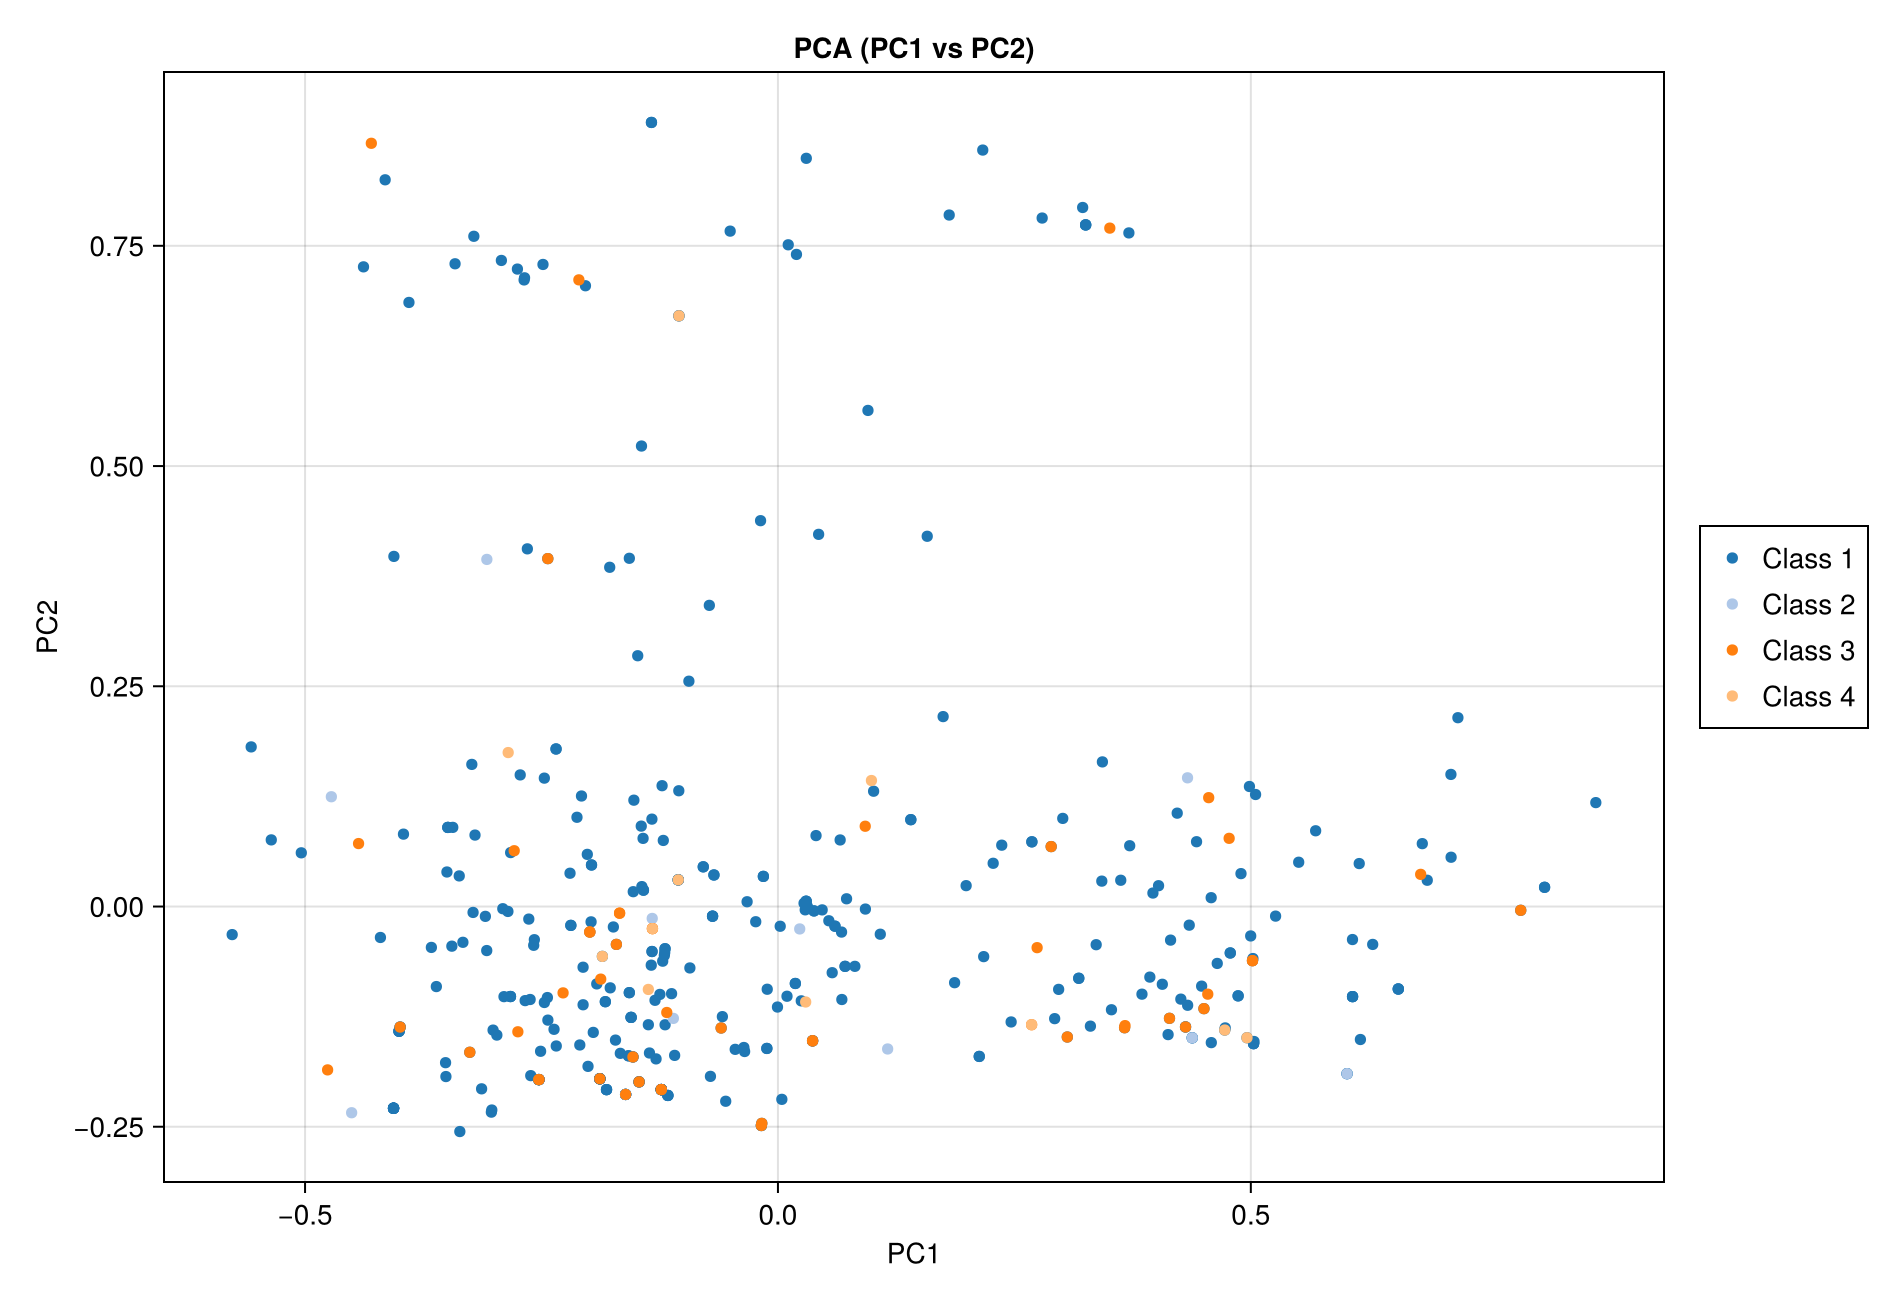

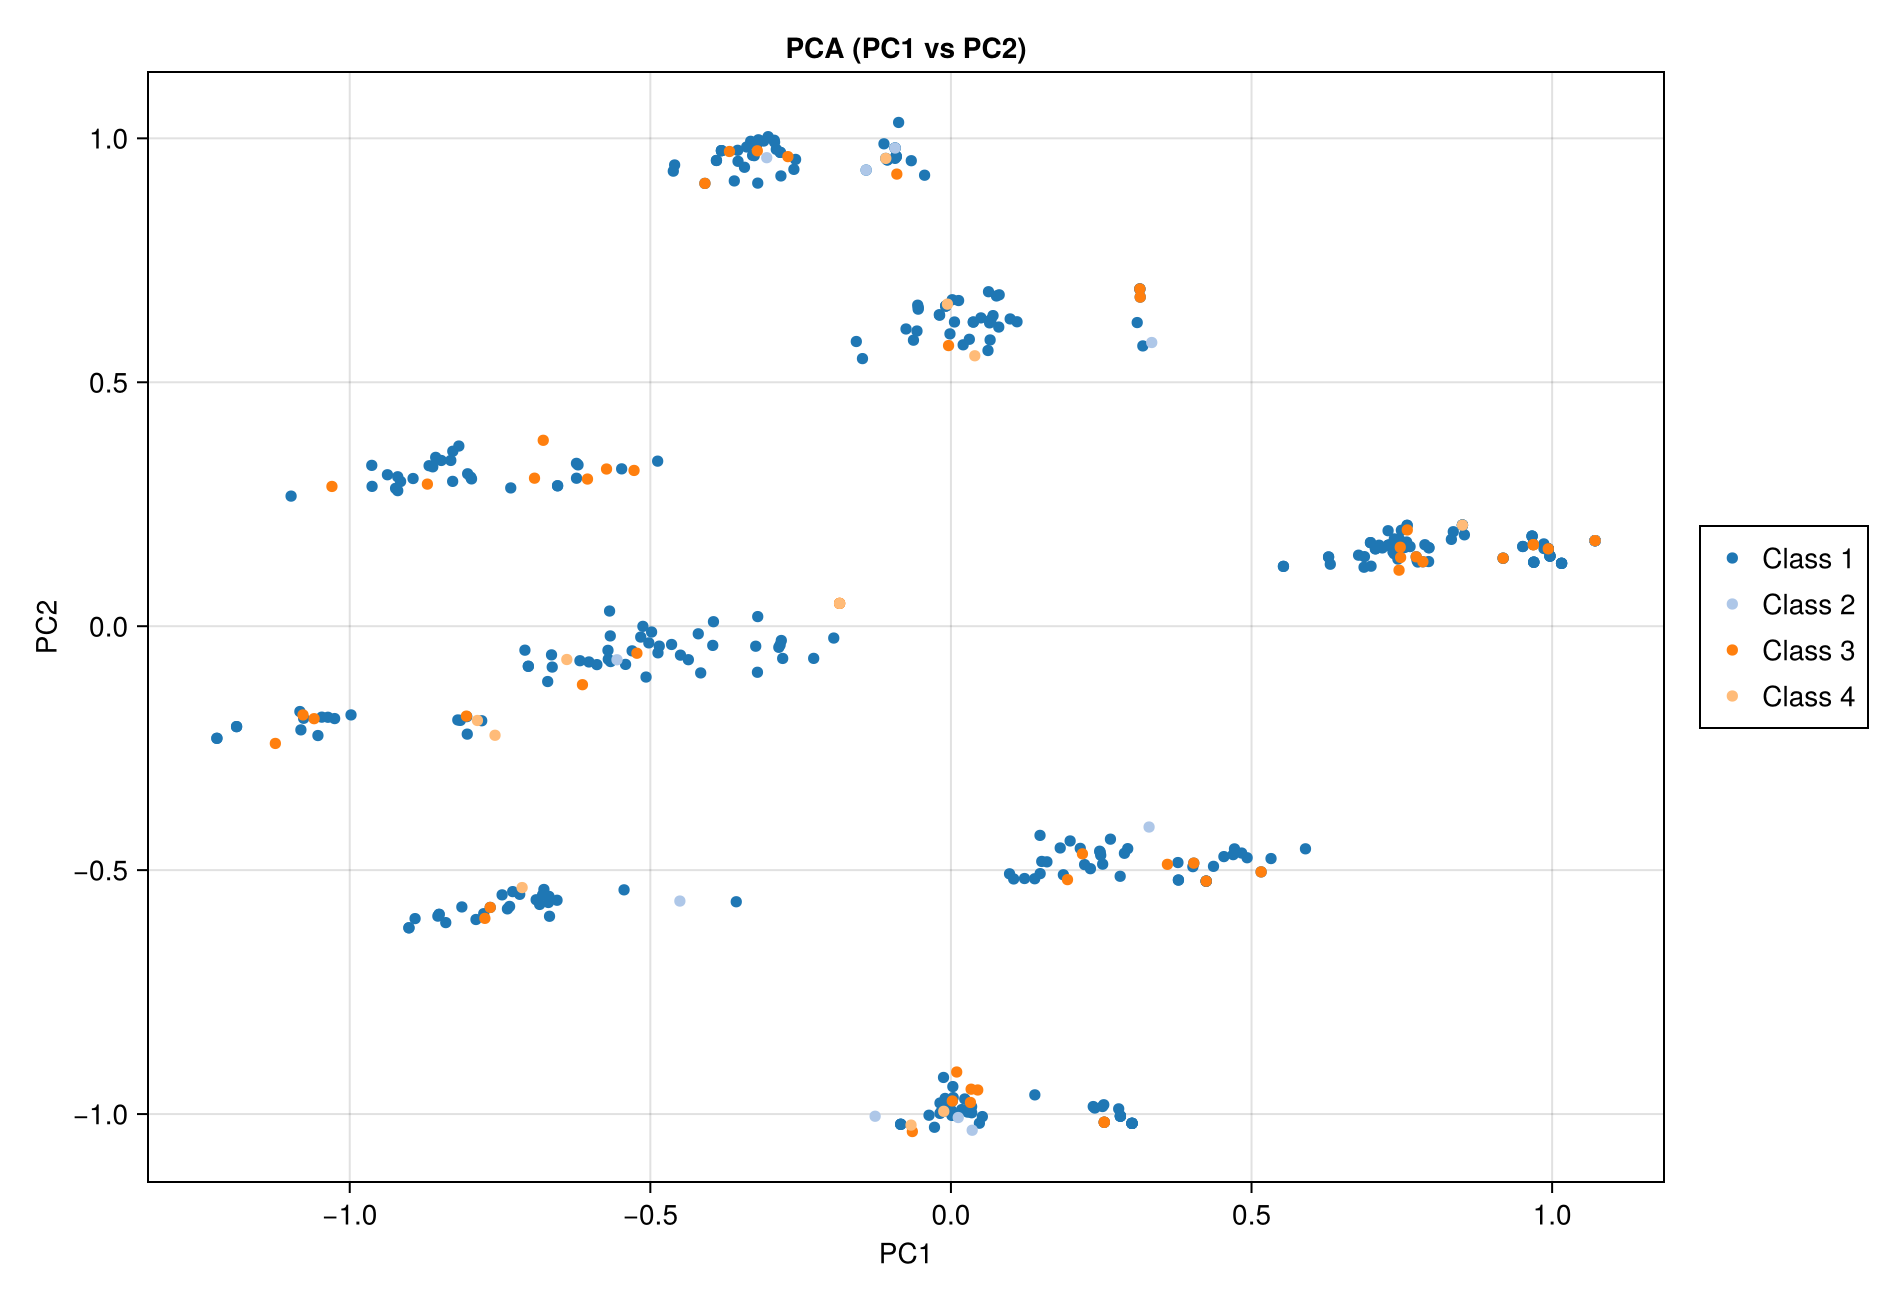

CairoMakie.Screen{IMAGE}


In [36]:
function pca_plot_2d(X; y=nothing, ncomp=2, standardize=false)
    X = Matrix{Float64}(X)

    # Always assume: X is features × samples
    Xsf = transpose(X)  # samples × features

    μ = mean(Xsf, dims=1)
    Xc = Xsf .- μ
    if standardize
        σ = std(Xc, dims=1)
        σ .= ifelse.(σ .== 0, 1.0, σ)
        Xc ./= σ
    end

    Xt = transpose(Xc)  # features × samples

    pca = MultivariateStats.fit(MultivariateStats.PCA, Xt; maxoutdim=ncomp)
    Zt  = MultivariateStats.transform(pca, Xt)   # ncomp × n_samples
    scores = transpose(Zt)                       # n_samples × ncomp

    loadings  = MultivariateStats.projection(pca) # n_features × ncomp
    explained = MultivariateStats.principalvars(pca) ./ MultivariateStats.tvar(pca)

    fig = Figure(size=(950, 650))
    ax = Axis(fig[1, 1], xlabel="PC1", ylabel="PC2", title="PCA (PC1 vs PC2)")

    if y === nothing
        scatter!(ax, scores[:, 1], scores[:, 2]; markersize=8)
    else
        @assert length(y) == size(scores, 1) "y must have one label per sample"
        @assert all(1 .<= y .<= 4) "y must contain labels in 1:4"

        # 20 distinct colors; take first 16 (nice and clear)
        palette16 = Makie.to_colormap(:tab20)[1:4]

        # Plot per-class to get a clean legend
        for c in 1:4
            idx = findall(==(c), y)
            scatter!(
                ax,
                scores[idx, 1], scores[idx, 2];
                color = palette16[c],
                markersize = 8,
                label = "Class $c"
            )
        end

        Legend(fig[1, 2], ax; title="y (1–4)", framevisible=true)
    end

    return fig,
           scores[:, 1:min(5, size(scores, 2))],
           loadings[:, 1:min(5, size(loadings, 2))],
           explained[1:min(5, length(explained))],
           pca
end

function labels_from_dict(d::Dict{<:Any, <:AbstractVector})
    y = Vector{Int}(undef, length(d))

    i = 1
    for v in values(d)
        @assert length(v) == 4 "Each value must have length 4"
        _, idx = findmax(v)
        y[i] = idx
        i += 1
    end

    return y
end
colors_pep = labels_from_dict(peptides_full)
fig, pcs, loadings, explained, pca_model = pca_plot_2d(project, y=colors_pep)
display(fig)

fig2, pcs, loadings, explained, pca_model = pca_plot_2d(onehot_end, y=colors_pep)
display(fig2)

In [16]:
using LinearAlgebra

# ----------------------------
# Utilities
# ----------------------------
@inline sigmoid(z) = 1.0 / (1.0 + exp(-z))

# soft-thresholding prox for L1: prox_{tλ||.||1}(x) = sign(x)*max(|x|-tλ, 0)
@inline function soft_threshold(x::Float64, tλ::Float64)
    if x > tλ
        return x - tλ
    elseif x < -tλ
        return x + tλ
    else
        return 0.0
    end
end

function soft_threshold!(w::AbstractVector{Float64}, tλ::Float64)
    @inbounds for i in eachindex(w)
        w[i] = soft_threshold(w[i], tλ)
    end
    return w
end

# Logistic loss (average) + L1 penalty (not including bias)
function logistic_l1_objective(w::AbstractVector{Float64}, b::Float64,
                               X::AbstractMatrix{Float64}, y::AbstractVector{Float64},
                               λ::Float64)
    D, N = size(X)
    @assert length(w) == D
    @assert length(y) == N

    z = vec(w' * X) .+ b

    eps = 1e-12
    loss = 0.0
    @inbounds for j in 1:N
        p = clamp(sigmoid(z[j]), eps, 1.0 - eps)
        loss += -(y[j]*log(p) + (1.0-y[j])*log(1.0-p))
    end
    loss /= N

    pen = sum(abs, w)  # true L1
    return loss + λ * pen
end

# Gradient of average logistic loss (no L1 part) wrt w and b
function logistic_grad!(gw::Vector{Float64}, gb_ref::Base.RefValue{Float64},
                        w::AbstractVector{Float64}, b::Float64,
                        X::AbstractMatrix{Float64}, y::AbstractVector{Float64})
    D, N = size(X)
    z = vec(w' * X) .+ b

    # err = σ(z) - y
    err = similar(z)
    @inbounds for j in 1:N
        err[j] = sigmoid(z[j]) - y[j]
    end

    # gw = X*err / N
    mul!(gw, X, err)   # gw = X*err
    gw ./= N

    gb_ref[] = sum(err) / N
    return nothing
end

# A safe step size based on Lipschitz constant upper bound:
# Lw <= (1/(4N)) * ||X||_2^2  (for logistic loss average)
# so step <= 1/Lw  (bias handled separately by plain gradient step)
function suggested_step_size(X::AbstractMatrix{Float64})
    D, N = size(X)
    # spectral norm (2-norm) of X:
    s = opnorm(X, 2)
    Lw = (s*s) / (4.0*N + 1e-30)
    return 1.0 / (Lw + 1e-12)
end

"""
Train sparse logistic regression with L1 on weights using FISTA (proximal gradient).

Minimize:
  (1/N) Σ_j logloss(y_j, σ(wᵀx_j + b))  +  λ ||w||_1

- L1 is applied ONLY to w, not to b.
- Enforces sparsity via soft-thresholding.

Returns:
  (status=:ok, w=..., b=..., history=...)
"""
function train_logreg_l1_fista(X::AbstractMatrix{Float64}, y::AbstractVector{Float64};
                               λ::Float64 = 1.0,
                               maxiters::Int = 500,
                               step::Union{Nothing,Float64} = nothing,
                               tol::Float64 = 1e-6,
                               record_every::Int = 10,
                               verbose::Bool = false)
    D, N = size(X)
    @assert length(y) == N

    t = step === nothing ? suggested_step_size(X) : step

    # parameters
    w  = zeros(Float64, D)
    b  = 0.0

    # FISTA state
    w_prev = copy(w)
    b_prev = b
    w_y    = copy(w)
    b_y    = b
    tk = 1.0

    gw = zeros(Float64, D)
    gb = Ref(0.0)

    # optional history
    obj_hist = Float64[]
    iter_hist = Int[]

    # helper: record objective occasionally
    function record!(it)
        push!(iter_hist, it)
        push!(obj_hist, logistic_l1_objective(w, b, X, y, λ))
    end

    record!(0)

    for it in 1:maxiters
        # gradient at extrapolated point (w_y, b_y)
        logistic_grad!(gw, gb, w_y, b_y, X, y)

        # gradient step
        w_new = w_y .- t .* gw
        b_new = b_y - t * gb[]

        # proximal step on weights only
        soft_threshold!(w_new, t*λ)

        # FISTA momentum
        tk_new = 0.5 * (1.0 + sqrt(1.0 + 4.0*tk*tk))
        α = (tk - 1.0) / tk_new

        # update extrapolated point
        w_y .= w_new .+ α .* (w_new .- w)
        b_y  = b_new + α * (b_new - b)

        # update main iterate
        w_prev .= w
        b_prev  = b
        w .= w_new
        b  = b_new
        tk = tk_new

        # stopping check: relative change in parameters
        dw = norm(w .- w_prev) / (norm(w_prev) + 1e-12)
        db = abs(b - b_prev) / (abs(b_prev) + 1e-12)

        if (it % record_every == 0) || (it == maxiters)
            record!(it)
            if verbose
                frac0 = sum(abs.(w) .< 1e-10) / length(w)
                println("it=$it  obj=$(obj_hist[end])  step=$t  dw=$dw  db=$db  frac_zero≈$(round(frac0, digits=3))")
            end
        end

        if max(dw, db) < tol
            if (iter_hist[end] != it)
                record!(it)
            end
            return (status=:ok, w=w, b=b, history=(iters=iter_hist, obj=obj_hist, step=t))
        end
    end

    return (status=:ok, w=w, b=b, history=(iters=iter_hist, obj=obj_hist, step=t))
end

# ----------------------------
# Per-class training wrapper (matches your earlier API style)
# ----------------------------
function train_binary_models_per_class(indexed::NamedTuple,
                                              alphabet::Vector{Char},
                                              char_to_index::Dict{Char,Int};
                                              λ::Float64 = 1.0,
                                              maxiters::Int = 800,
                                              tol::Float64 = 1e-6,
                                              step::Union{Nothing,Float64} = nothing,
                                              record_every::Int = 20,
                                              verbose::Bool = false)

    class_names     = indexed.class_names
    class_to_idx    = indexed.class_to_idx
    keys_by_class   = indexed.keys_by_class
    labels_by_class = indexed.labels_by_class

    models_vec = Vector{Any}(undef, length(class_names))
    models_by_class = Dict{String, Any}()

    for i in eachindex(class_names)
        cname = class_names[i]
        keys  = keys_by_class[i]
        yint  = labels_by_class[i]

        if isempty(keys)
            m = (status=:empty,)
            models_vec[i] = m
            models_by_class[cname] = m
            continue
        end

        # checks
        L = length(keys[1])
        @assert all(length(s) == L for s in keys) "Class $cname: keys have different lengths"
        @assert all(v -> (v == 0 || v == 1), yint) "Class $cname: labels must be 0/1 only"

        if all(v -> v == 0, yint) || all(v -> v == 1, yint)
            m = (status=:degenerate, only_label=yint[1])
            models_vec[i] = m
            models_by_class[cname] = m
            continue
        end

        for s in keys, c in s
            @assert haskey(char_to_index, c) "Class $cname: character '$c' not in char_to_index"
        end

        y = Float64.(yint)  # 0/1
        X = Float64.(onehot_encode_2d(keys, alphabet, char_to_index))  # (D,N)
        D, N = size(X)
        @assert length(y) == N "Class $cname: labels length != number of samples"

        # Train sparse model
        mfit = train_logreg_l1_fista(X, y;
            λ=λ,
            maxiters=maxiters,
            step=step,
            tol=tol,
            record_every=record_every,
            verbose=verbose
        )

        m = (status=:ok, w=mfit.w, b=mfit.b, history=mfit.history)
        models_vec[i] = m
        models_by_class[cname] = m
    end

    pack = (class_names=class_names, class_to_idx=class_to_idx, models=models_vec)
    return models_by_class, pack
end

# ----------------------------
# Prediction helpers
# ----------------------------
predict_proba(model, X::AbstractMatrix) = vec(sigmoid.(model.w' * X .+ model.b))
predict_label(model, X::AbstractMatrix; threshold=0.5) =
    map(p -> p ≥ threshold ? 1 : 0, predict_proba(model, X))


predict_label (generic function with 1 method)

In [18]:
models_by_class_4, pack_4 = train_binary_models_per_class(indexed_4, alphabet, alphabet_dict; λ=0.001, maxiters=1200, tol=1e-6, verbose=true)

alphabet_str = string.(alphabet)
A = length(alphabet)

# infer L from any non-empty class in indexed_4
first_nonempty_i = findfirst(i -> !isempty(indexed_4.keys_by_class[i]), eachindex(indexed_4.class_names))
@assert first_nonempty_i !== nothing "No training keys found in indexed_4."
L = length(indexed_4.keys_by_class[first_nonempty_i][1])

# pick the first 4 class names (or replace with your own list)
classes4 = pack_4.class_names[1:min(4, length(pack_4.class_names))]

for cname in classes4
    m = models_by_class_4[cname]
    println("class=$(cname) status=$(m.status)")
    if m.status == :ok
        save_sequence_logo_from_w(m.w, A, L;
            alphabet_str=alphabet_str,
            title="Weights logo: $(cname)",
            filename="logo_$(cname).png",
            show=false
        )
        println("saved logo_$(cname).png")
    end
end


it=20  obj=0.3372566711441822  step=0.1742487577374911  dw=0.049070577105277416  db=0.03742635301610817  frac_zero≈0.516
it=40  obj=0.3198118600025376  step=0.1742487577374911  dw=0.019766479106070788  db=0.019747573617387593  frac_zero≈0.601
it=60  obj=0.31437040492151125  step=0.1742487577374911  dw=0.012739875834049128  db=0.0147093160759227  frac_zero≈0.689
it=80  obj=0.3110643224638457  step=0.1742487577374911  dw=0.010206875255841403  db=0.01281045856496171  frac_zero≈0.752
it=100  obj=0.3089867590388318  step=0.1742487577374911  dw=0.008029969647307929  db=0.011011429989840707  frac_zero≈0.8
it=120  obj=0.3076720154146565  step=0.1742487577374911  dw=0.006362239706182433  db=0.00944085465132838  frac_zero≈0.832
it=140  obj=0.30672064511261454  step=0.1742487577374911  dw=0.005434972241049644  db=0.008228765302824365  frac_zero≈0.859
it=160  obj=0.3060897435315736  step=0.1742487577374911  dw=0.004393304295989115  db=0.007588787857065014  frac_zero≈0.878
it=180  obj=0.30560614335

In [39]:
using JLD2

# Save only m.w for models that are :ok
w_by_class = Dict{String, Any}()

for (cname, m) in pairs(models_by_class_4)
    if m.status == :ok
        w_by_class[string(cname)] = m.w
    end
end

@save "models_by_class_4_w.jld2" w_by_class
println("Saved weights to models_by_class_4_w.jld2")


Saved weights to models_by_class_4_w.jld2


In [41]:
using JLD2

@load "models_by_class_4_w.jld2" w_by_class

# Get weights for a class
w = w_by_class["#CLASS 1"]

# Or loop through all recovered weights
for (cname, w) in pairs(w_by_class)
    println("class=$cname  size=", size(w))
end


class=#CLASS 1  size=(1701,)
class=#CLASS 3  size=(1701,)
class=#CLASS 4  size=(1701,)
class=#CLASS 2  size=(1701,)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


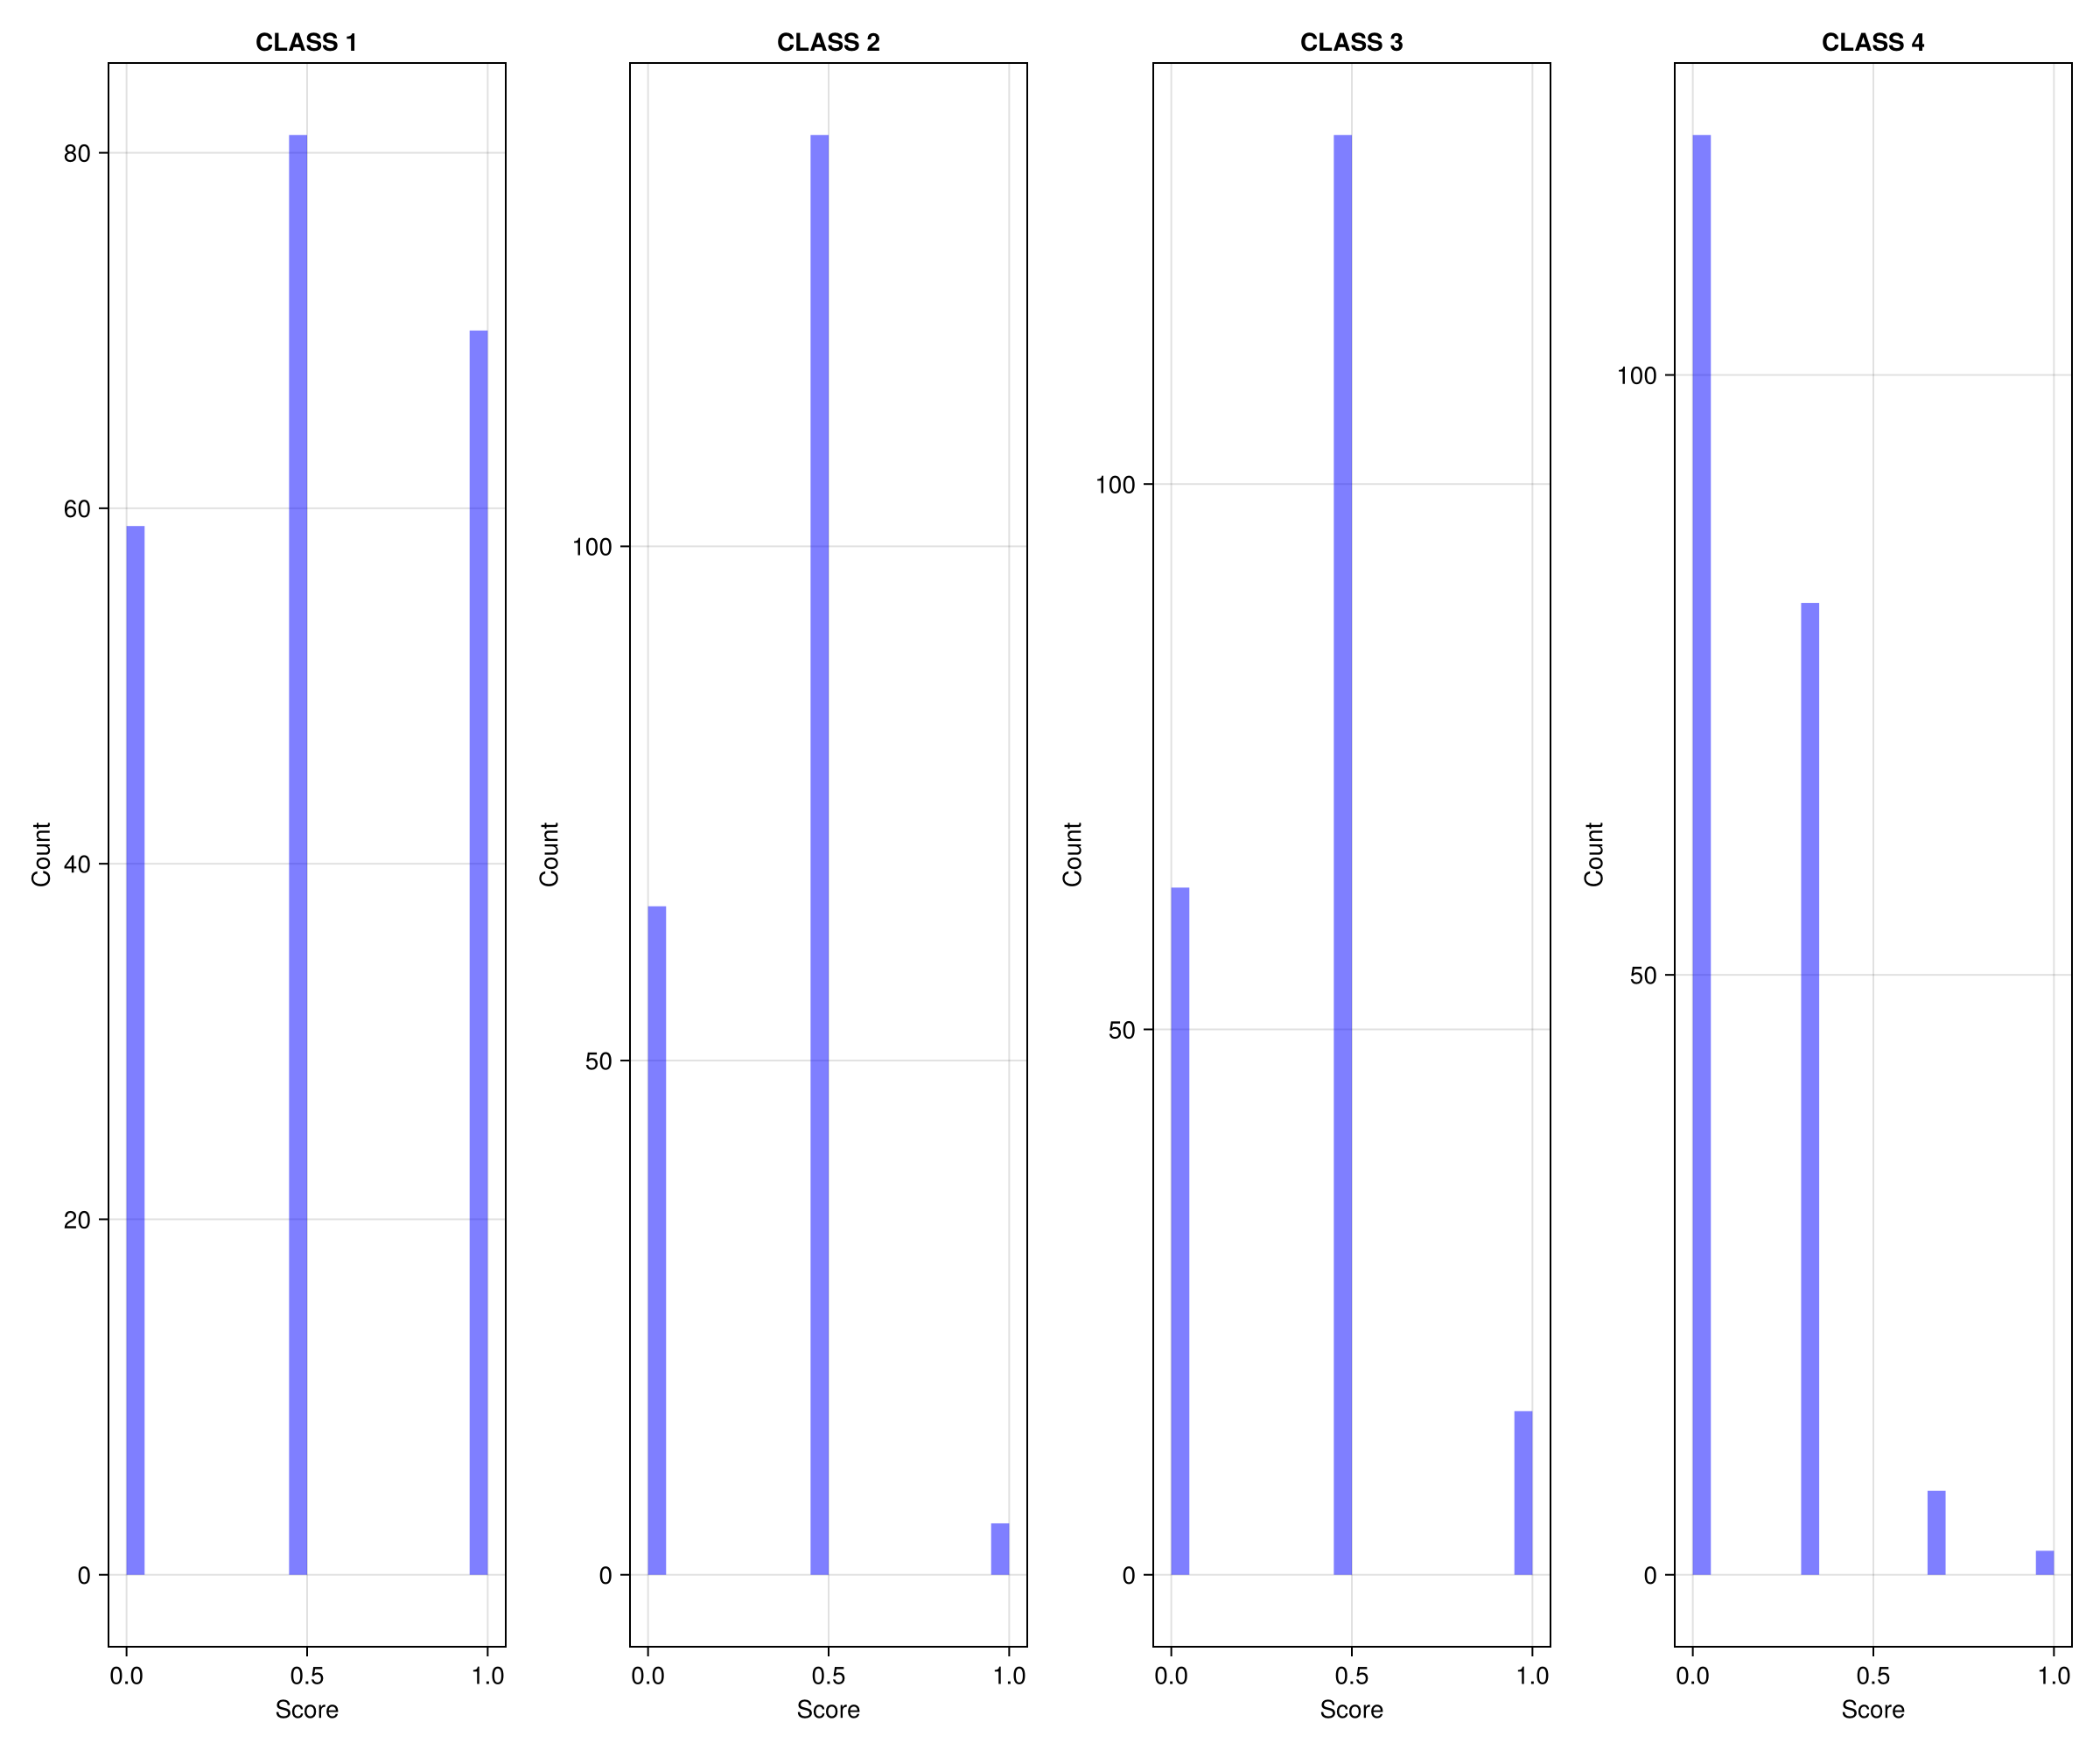

In [19]:
# Or flatten into a single vector of all elements
all_elements_Stiffler = vcat([value.elements for value in values(data_Stiffler)]...)
file_content_reduced = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides4.txt", String)
dict_S = best_strings_per_class(file_content_reduced, all_elements_Stiffler)
peptides_full_S = score_strings(file_content_reduced, all_elements_Stiffler)
plot_histograms(peptides_full_S)

In [ ]:

"""
    collect_key_label_hits_per_class(best_out, data; matchfun=occursin)

Inputs:
- best_out = (best, best_score) from `best_strings_per_class`
    best[class] = Vector of winning strings for that class
- data[key] = (elements::Vector{String}, labels::Vector{Int})

For each class:
- scan all keys in `data`
- for each element index j:
    if any winning string matches elements[j] (default: substring via occursin)
        push key and labels[j]

Returns:
- indexed::NamedTuple with:
    class_names::Vector{String}
    class_to_idx::Dict{String,Int}
    keys_by_class::Vector{Vector{String}}
    labels_by_class::Vector{Vector{Int}}
    best_score::Dict{String,Float64}

- by_class::Dict{String, NamedTuple{(:keys,:labels),Tuple{Vector{String},Vector{Int}}}}

- summary::Dict{String, NamedTuple{
        (:n_label1,:keys_label1,:n_label0,:keys_label0),
        Tuple{Int,Vector{String},Int,Vector{String}}
    }}
  where:
    n_label1 = number of hits with label==1 for that class
    keys_label1 = unique dataset keys that produced at least one label==1 hit
    n_label0 = number of hits with label==0 for that class
    keys_label0 = unique dataset keys that produced at least one label==0 hit
"""
function collect_key_label_hits_per_class_summary(
    best_out::Tuple{
        Dict{String, Vector{String}},
        Dict{String, Float64}
    },
    data::Dict{String, NamedTuple{(:elements,:labels), Tuple{Vector{String}, Vector{Int}}}};
    matchfun = occursin,  # call as matchfun(winner, element)
)
    best, best_score = best_out

    # Stable ordering => easy indexing across classes
    class_names  = sort(collect(keys(best)))
    class_to_idx = Dict(c => i for (i, c) in enumerate(class_names))
    n = length(class_names)

    keys_by_class   = [String[] for _ in 1:n]
    labels_by_class = [Int[]    for _ in 1:n]

    # NEW: label==1 stats
    n_label1_by_class = zeros(Int, n)
    keys_label1_by_class = [String[] for _ in 1:n]
    seen_label1_keys_by_class = [Set{String}() for _ in 1:n]  # uniqueness

    # NEW: label==0 stats
    n_label0_by_class = zeros(Int, n)
    keys_label0_by_class = [String[] for _ in 1:n]
    seen_label0_keys_by_class = [Set{String}() for _ in 1:n]  # uniqueness

    for (i, class_name) in enumerate(class_names)
        winners = best[class_name]
        kvec = keys_by_class[i]
        lvec = labels_by_class[i]

        k1vec = keys_label1_by_class[i]
        seen1 = seen_label1_keys_by_class[i]

        k0vec = keys_label0_by_class[i]
        seen0 = seen_label0_keys_by_class[i]

        # scan entire dataset
        for (key, nt) in data
            elems = nt.elements
            labs  = nt.labels

            @inbounds for j in eachindex(elems)
                e = elems[j]

                # does e match any winner?
                hit = false
                for w in winners
                    if matchfun(w, e)
                        hit = true
                        break
                    end
                end

                if hit
                    lab = labs[j]

                    push!(kvec, key)  # dataset KEY
                    push!(lvec, lab)  # aligned label

                    # record per-label stats
                    if lab == 1
                        n_label1_by_class[i] += 1
                        if !(key in seen1)
                            push!(k1vec, key)
                            push!(seen1, key)
                        end
                    elseif lab == 0
                        n_label0_by_class[i] += 1
                        if !(key in seen0)
                            push!(k0vec, key)
                            push!(seen0, key)
                        end
                    end
                end
            end
        end
    end

    # Convenience views (by class name)
    by_class = Dict{String, NamedTuple{(:keys,:labels),Tuple{Vector{String},Vector{Int}}}}()
    summary  = Dict{String, NamedTuple{
        (:n_label1,:keys_label1,:n_label0,:keys_label0),
        Tuple{Int,Vector{String},Int,Vector{String}}
    }}()

    for (i, c) in enumerate(class_names)
        by_class[c] = (keys = keys_by_class[i], labels = labels_by_class[i])
        summary[c]  = (
            n_label1     = n_label1_by_class[i],
            keys_label1  = keys_label1_by_class[i],
            n_label0     = n_label0_by_class[i],
            keys_label0  = keys_label0_by_class[i],
        )
    end

    indexed = (
        class_names     = class_names,
        class_to_idx    = class_to_idx,
        keys_by_class   = keys_by_class,
        labels_by_class = labels_by_class,
        best_score      = best_score
    )

    return indexed, by_class, summary
end



indexed, by_class, summary = collect_key_label_hits_per_class_summary(dict_S, data_Stiffler)

summary["#CLASS 1"].n_label1          # how many label==1 hits in class "1"
summary["#CLASS 1"].keys_label1       # which dataset keys produced those label==1 hits
summary["#CLASS 1"].n_label0
summary["#CLASS 1"].keys_label0

ciao = onehot_encode_2d(summary["#CLASS 1"].keys_label1, alphabet, alphabet_dict)
ciao2 = onehot_encode_2d(summary["#CLASS 1"].keys_label0, alphabet, alphabet_dict)

tot=mean(ciao; dims=2)-mean(ciao2; dims=2)

save_sequence_logo_from_w(vec(tot), A, L;
            alphabet_str=alphabet_str,
            title="Weights logo: data_Stiffler",
            filename="diff.png",
            show=false,
            center_values = false
)

println(length(unique(summary["#CLASS 1"].keys_label1)))
println(length(unique(summary["#CLASS 1"].keys_label0)))

64
84


In [ ]:
indexed_4_S, by_class_4_S = collect_key_label_hits_per_class(dict_S, data_Stiffler)
models_by_class_4_S, pack_4_S = train_binary_models_per_class(indexed_4_S, alphabet, alphabet_dict; λ=0.0008, maxiters=1200, tol=1e-6, verbose=true)

alphabet_str = string.(alphabet)
A = length(alphabet)

# infer L from any non-empty class in indexed_4
first_nonempty_i = findfirst(i -> !isempty(indexed_4_S.keys_by_class[i]), eachindex(indexed_4_S.class_names))
@assert first_nonempty_i !== nothing "No training keys found in indexed_4_S."
L = length(indexed_4_S.keys_by_class[first_nonempty_i][1])

# pick the first 4 class names (or replace with your own list)
classes4 = pack_4_S.class_names[1:min(4, length(pack_4_S.class_names))]

for cname in classes4
    m = models_by_class_4_S[cname]
    println("class=$(cname) status=$(m.status)")
    if m.status == :ok
        save_sequence_logo_from_w(m.w, A, L;
            alphabet_str=alphabet_str,
            title="Weights logo: $(cname)",
            filename="logo_$(cname)_Stiffler.png",
            show=false
        )
        println("saved logo_$(cname).png")
    end
end

LoadError: UndefVarError: `dict_S` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
indexed_4_S, by_class_4_S = collect_key_label_hits_per_class(dict_S, data_Stiffler)
models_by_class_4_S, pack_4_S = train_binary_models_per_class(indexed_4_S, alphabet, alphabet_dict; λ=0.0008, maxiters=1200, tol=1e-6, verbose=true)


In [30]:
all_elements_control = vcat([value.elements for value in values(D_control)]...)
file_content_reduced = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides4.txt", String)
dict_control = best_strings_per_class(file_content_reduced, all_elements_control)
peptides_full_control = score_strings(file_content_reduced, all_elements_control)
indexed_4_control, by_class_4_control = collect_key_label_hits_per_class(dict_control, D_control)
models_by_class_4_control, pack_4_control = train_binary_models_per_class(indexed_4_control, alphabet, alphabet_dict; λ=0.0008, maxiters=1200, tol=1e-6, verbose=true)

it=20  obj=0.5494425629115017  step=0.12347423437720327  dw=0.04725136029887363  db=0.04319104472060357  frac_zero≈0.587
it=40  obj=0.5354404156762314  step=0.12347423437720327  dw=0.016835241806016633  db=0.011893771909214345  frac_zero≈0.621
it=60  obj=0.5305030717587171  step=0.12347423437720327  dw=0.012550586321124628  db=0.012146420920181266  frac_zero≈0.648
it=80  obj=0.5276299248851518  step=0.12347423437720327  dw=0.009906891393450903  db=0.009903765886918804  frac_zero≈0.712
it=100  obj=0.5259482824740948  step=0.12347423437720327  dw=0.0077136478771237535  db=0.010278693090997378  frac_zero≈0.76
it=120  obj=0.5249705762135899  step=0.12347423437720327  dw=0.006197473262387767  db=0.007275925685694612  frac_zero≈0.797
it=140  obj=0.5242158806035073  step=0.12347423437720327  dw=0.005440040526257255  db=0.0064390075058577845  frac_zero≈0.828
it=160  obj=0.5236054878588468  step=0.12347423437720327  dw=0.004960123219520018  db=0.00824139506644974  frac_zero≈0.855
it=180  obj=0.

(Dict{String, Any}("#CLASS 1" => (status = :ok, w = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], b = -1.8712404312671174, history = (iters = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180  …  1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200], obj = [0.6931471805599269, 0.5494425629115017, 0.5354404156762314, 0.5305030717587171, 0.5276299248851518, 0.5259482824740948, 0.5249705762135899, 0.5242158806035073, 0.5236054878588468, 0.5230962251934826  …  0.5201343763395397, 0.5201332750788473, 0.520130289660754, 0.5201276992746422, 0.5201251635220463, 0.5201230997220815, 0.5201220848346487, 0.5201214314251068, 0.5201205882371299, 0.5201202164513163], step = 0.12347423437720327)), "#CLASS 3" => (status = :ok, w = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], b = -2.5873453984642314, history = (iters = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180  …  1020, 1040, 1060, 10

In [32]:
classes4 = pack_4_control.class_names[1:min(4, length(pack_4_control.class_names))]

for cname in classes4
    m = models_by_class_4_control[cname]
    println("class=$(cname) status=$(m.status)")
    if m.status == :ok
        save_sequence_logo_from_w(m.w, A, L;
            alphabet_str=alphabet_str,
            title="Weights logo: $(cname) control",
            filename="logo_$(cname)_control.png",
            show=false
        )
        println("saved logo_$(cname).png")
    end
end

class=#CLASS 1 status=ok
saved logo_#CLASS 1.png
class=#CLASS 2 status=ok
saved logo_#CLASS 2.png
class=#CLASS 3 status=ok
saved logo_#CLASS 3.png
class=#CLASS 4 status=ok
saved logo_#CLASS 4.png


In [ ]:
eval_out = evaluate_linear_models_by_class(
    models_by_class_4,
    indexedindexed_4_S,
    alphabet,
    alphabet_dict;
    threshold=0.5,
    verbose=true
)

eval_out.overall
eval_out.macro
println(eval_out.by_class["#CLASS 1"])
println(eval_out.by_class["#CLASS 2"])
println(eval_out.by_class["#CLASS 3"])

In [38]:
using bind_RBM: evaluate_linear_models_by_class

eval_out = evaluate_linear_models_by_class(
    models_by_class_4,
    indexed_4_control,
    alphabet,
    alphabet_dict;
    threshold=0.305,
    verbose=true
)

eval_out.overall
eval_out.macro
println(eval_out.by_class["#CLASS 1"])
println(eval_out.by_class["#CLASS 2"])
println(eval_out.by_class["#CLASS 3"])

Linear model evaluation summary
  Classes evaluated: 4
  Total samples:     1347
  Overall accuracy:  0.6585
  Overall F1:        0.4923
  Macro AUC:         0.7782
(status = :ok, class_name = "#CLASS 1", n = 1147, threshold = 0.305, positive = 555, negative = 592, probs = [0.08204533395162739, 0.08204533395162739, 0.08204533395162739, 0.08204533395162739, 0.08204533395162739, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.5670441404733697, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.08067699674620968, 0.05327084755900104, 0.3204218620469773, 0.320

In [32]:
ciao = onehot_encode_2d(collect(keys(data_Gogl)), alphabet, alphabet_dict)
ciao = mean(ciao; dims=2)  # average one-hot across all samples (per character)
save_sequence_logo_from_w(vec(ciao), A, L;
            alphabet_str=alphabet_str,
            title="Weights logo: data_Gogl",
            filename="logo_data_Gogl.png",
            show=false,
            center_values = false

        )


"logo_data_Gogl.png"

In [33]:
ciao = onehot_encode_2d(collect(keys(data_Stiffler)), alphabet, alphabet_dict)
ciao = mean(ciao; dims=2)  # average one-hot across all samples (per character)
save_sequence_logo_from_w(vec(ciao), A, L;
            alphabet_str=alphabet_str,
            title="Weights logo: data_Stiffler",
            filename="logo_data_Stiffler.png",
            show=false,
            center_values = false

        )


"logo_data_Stiffler.png"

=====================================================================================


I WILL REDUCE BOTH THE COVARIANCE MATRIX AND THE PEPTIDES AND LOOK AT Q_INTER * v

In [84]:
data_Gogl = create_binding_dictionary_Gogl("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt")

results = String[]
class_array= Int[]

for (key, value) in data_Gogl
    for (element, label) in zip(value.elements, value.labels)
        if label == 0 || label == 1
            push!(results, key * element)
            push!(class_array, label)
        end
    end
end
full_label = one_hot_encode(results, alphabet, alphabet_dict)   
y = vec(Float32.(class_array))
println("full_label size: ", size(full_label))
keep = [1:81; 87:size(full_label,2)]
B = full_label[:, keep, :]
println("B size: ", size(B))

Skipped rows: 2037
full_label size: (21, 91, 68442)
B size: (21, 86, 68442)


In [85]:
function zero_to_target_nonzero!(A::AbstractMatrix{<:AbstractFloat}, frac_nonzero::Real)
    n = length(A)
    n == 0 && return A, NaN, NaN

    f = float(frac_nonzero)
    (0.0 <= f <= 1.0) || throw(ArgumentError("frac_nonzero must be a fraction in [0, 1], got $frac_nonzero"))

    m = clamp(round(Int, f * n), 0, n)
    T = eltype(A)

    thr_abs::T = if m == 0
        typemax(T)              # abs(x) < thr_abs for all finite x -> all zeroed
    elseif m == n
        zero(T)                 # abs(x) < 0 is never true -> nothing zeroed
    else
        v = abs.(vec(copy(A)))  # work on magnitudes
        k = n - m + 1           # k-th smallest magnitude is the cutoff
        partialsort!(v, k)
        v[k]
    end

    @inbounds for i in eachindex(A)
        if abs(A[i]) < thr_abs
            A[i] = zero(T)
        end
    end

    achieved_frac_nonzero = count(!iszero, A) / n
    return A, thr_abs
end


zero_to_target_nonzero! (generic function with 1 method)

In [86]:
using bind_RBM: Q_inter_centered
Q_reduced_center = Q_inter_centered(B, split_idx, class_array)
Q_reduced = Q_inter(B, split_idx, class_array, mean(class_array))

1701×105 Matrix{Float64}:
  0.0           0.0          0.0          …   0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
 -0.000423103  -8.22409e-5  -0.000534566     -2.74136e-5   0.0  -0.000109654
  0.0           0.0          0.0              0.0          0.0   0.0
  0.0           0.0          0.0          …   0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
  0.0           0.0          0.0          …   0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
  0.0           0.0          0.0              0.0          0.0   0.0
  ⋮                                       ⋱                     
 -0.

In [87]:
Q_sparse_centered, treshold = zero_to_target_nonzero!(Q_reduced_center, 0.0005)
Q_sparse, treshold = zero_to_target_nonzero!(Q_reduced, 0.0005)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0.0656363314679028)

In [6]:
F = svd(Q_sparse)          # factorization object
U = F.U
S = F.S            # vector of singular values
V = F.V            # note: A ≈ U * Diagonal(S) * V'

105×105 adjoint(::Matrix{Float32}) with eltype Float32:
  0.0        0.0       0.0       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                              ⋱

# Sparse SVD: Mathematical Summary

We seek sparse vectors \( u \) and \( v \) that capture maximal variance of a matrix \( Q \) while penalizing non-zero entries using the \( \ell_1 \) norm (where \( \|x\|_1 = \sum_i |x_i| \)).

---

## 1. Optimization Goal

We solve the following constrained optimization problem:

\[
\max_{u, v} \quad u^\top Q v \;-\; \mu_u \|u\|_1 \;-\; \mu_v \|v\|_1
\]

subject to

\[
\|u\|_2 \le 1, \quad \|v\|_2 \le 1.
\]

Here, \( \mu_u \) and \( \mu_v \) control the sparsity level of \( u \) and \( v \), respectively.

---

## 2. Iterative Update Steps

Starting from an initial vector \( v \), we alternate between updating \( u \) and \( v \):

**Update \( u \):**
\[
u \leftarrow \mathcal{S}_{\mu_u}(Q v)
\]

**Update \( v \):**
\[
v \leftarrow \mathcal{S}_{\mu_v}(Q^\top u)
\]

**Normalization:**
\[
u \leftarrow \frac{u}{\|u\|_2}, \qquad v \leftarrow \frac{v}{\|v\|_2}
\]

---

## 3. Soft-Thresholding Operator

The soft-thresholding operator \( \mathcal{S}_\mu \) is defined elementwise as:

\[
\mathcal{S}_\mu(x)_i = \operatorname{sign}(x_i)\,\max\left(|x_i| - \mu,\, 0\right).
\]

This step enforces sparsity by shrinking small coefficients to zero.

---

## 4. Deflation for Multiple Components

To extract multiple sparse components, we use deflation. After computing one component \( (u, \sigma, v) \), we update the matrix:

\[
Q_{\text{next}} = Q_{\text{curr}} - \sigma \, u v^\top.
\]

This removes the contribution of the current component before computing the next one. Repeating this process yields \( k \) sparse singular components.


In [66]:
using LinearAlgebra
using SparseArrays
using NPZ

"""
    save_sparse_svd_logos(filename::AbstractString, Q_reduced_center;
                          n_symbols::Int=21, k::Int=5, sparsity_param::Real=0.0007,
                          max_iter::Int=100, tol::Real=1e-6)

Compute a simple sparse SVD via iterative soft-thresholding + deflation, reshape the
left/right singular vectors into "logos" tensors of shape (k, n_symbols, L),
and save `U`, `V`, `S` to an NPZ file at `filename`.

Inputs
- `filename`: output `.npz` file path
- `Q_reduced_center`: matrix to decompose (dense or sparse)

Keyword args
- `n_symbols`: alphabet size used for reshaping
- `k`: number of sparse components to extract
- `sparsity_param`: soft-threshold parameter (applied to both u and v)
- `max_iter`, `tol`: iteration controls for the sparse power method

Returns
- `(Ulogos, Vlogos, S)` as `(Array{Float32,3}, Array{Float32,3}, Vector{Float32})`
"""
function save_sparse_svd_logos(filename::AbstractString, Q_reduced_center;
                               n_symbols::Int=21, k::Int=5, sparsity_param::Real=0.0007,
                               max_iter::Int=100, tol::Real=1e-6)

    # --- Custom Function for Sparse SVD (local, uses LinearAlgebra) ---
    function find_sparse_svd(M; max_iter::Int=100, tol::Real=1e-6, mu_u::Real=0.1, mu_v::Real=0.1)
        n, m = size(M)

        v = randn(m)
        nv = norm(v)
        v = nv > 0 ? v / nv : v
        u = zeros(eltype(v), n)

        for _ in 1:max_iter
            v_old = copy(v)

            u = M * v
            u = sign.(u) .* max.(0, abs.(u) .- mu_u)
            nu = norm(u)
            if nu > 0
                u ./= nu
            end

            v = M' * u
            v = sign.(v) .* max.(0, abs.(v) .- mu_v)
            nv = norm(v)
            if nv > 0
                v ./= nv
            end

            if norm(v .- v_old) < tol
                break
            end
        end

        sigma = norm(M * v)
        return u, sigma, v
    end

    # --- Main with Deflation ---
    U_sparse_mat = Array{Float32}(undef, size(Q_reduced_center, 1), k)
    V_sparse_mat = Array{Float32}(undef, size(Q_reduced_center, 2), k)
    S_sparse_vec = Vector{Float32}(undef, k)

    Q_deflated = copy(Q_reduced_center)

    for i in 1:k
        println("Computing sparse component $i...")

        u, s, v = find_sparse_svd(Q_deflated;
                                 max_iter=max_iter, tol=tol,
                                 mu_u=sparsity_param, mu_v=sparsity_param)

        U_sparse_mat[:, i] = Float32.(u)
        V_sparse_mat[:, i] = Float32.(v)
        S_sparse_vec[i] = Float32(s)

        # Deflation: Q = Q - s * u * v'
        Q_deflated = Q_deflated - s * (u * v')
    end

    # --- Reshape into logos tensors ---
    m = size(U_sparse_mat, 1)
    if m % n_symbols != 0
        throw(ArgumentError("size(Q,1)=$m is not divisible by n_symbols=$n_symbols for reshaping U."))
    end
    L_u = m ÷ n_symbols
    Ulogos = Array{Float32}(undef, k, n_symbols, L_u)
    for i in 1:k
        Ulogos[i, :, :] = reshape(U_sparse_mat[:, i], n_symbols, L_u)
    end

    n = size(V_sparse_mat, 1)
    if n % n_symbols != 0
        throw(ArgumentError("size(Q,2)=$n is not divisible by n_symbols=$n_symbols for reshaping V."))
    end
    L_v = n ÷ n_symbols
    Vlogos = Array{Float32}(undef, k, n_symbols, L_v)
    for i in 1:k
        Vlogos[i, :, :] = reshape(V_sparse_mat[:, i], n_symbols, L_v)
    end

    # --- Save ---
    npzwrite(filename, Dict(
        "U" => Ulogos,
        "V" => Vlogos,
        "S" => S_sparse_vec
    ))

    return Ulogos, Vlogos, S_sparse_vec
end


output_filename = "sparse_svd_center_top5.npz"
Ulogos, Vlogos, S_sparse_vec = save_sparse_svd_logos(output_filename, Q_reduced_center;
                                                       n_symbols=21, k=5, sparsity_param=0.00005,
                                                       max_iter=200, tol=1e-6)
output_filename2 = "sparse_svd_top5.npz"
Ulogos, Vlogos, S_sparse_vec = save_sparse_svd_logos(output_filename2, Q_reduced;
                                                       n_symbols=21, k=5, sparsity_param=0.00005,
                                                       max_iter=200, tol=1e-6)                            

Computing sparse component 1...
Computing sparse component 2...
Computing sparse component 3...
Computing sparse component 4...
Computing sparse component 5...
Computing sparse component 1...
Computing sparse component 2...
Computing sparse component 3...
Computing sparse component 4...
Computing sparse component 5...


(Float32[0.0 0.0 … 0.0 -0.31195185; 0.0 0.0 … 0.0 0.19889016; … ; 0.0 0.0 … 0.0 0.10503829; 0.0 0.0 … 0.0 -0.070771895;;; 0.0 0.0 … 0.0 -0.1263856; 0.0 0.0 … 0.0 -0.20878355; … ; 0.0 0.0 … 0.0 0.049505297; 0.0 0.0 … 0.0 0.022966566;;; 0.0 0.0 … 0.0 -0.05758782; 0.0 0.0 … 0.0 -0.11514355; … ; 0.0 0.0 … 0.0 -0.026508303; 0.0 0.0 … 0.0 -0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 -0.2802892; 0.0 0.0 … 0.0 0.18869573; … ; 0.0 0.0 … 0.0 0.10398436; 0.0 0.0 … 0.0 -0.009860533], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … 

In [9]:
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")

function unique_elements_from_dict(d::Dict)
    uniq = Set{String}()
    for v in values(d)
        union!(uniq, v.elements)
    end
    return uniq
end
uniq_Gogl = unique_elements_from_dict(data_Gogl)
keep_last5(it) = [last(s, min(5, lastindex(s))) for s in it]
els = sort!(collect(uniq_Gogl))     # Vector{String} (sorted = deterministic)

ending = keep_last5(els)   # ["CDEFG", "hi", "12345", "clair"]
onehot_end = onehot_encode_2d(ending, alphabet, alphabet_dict)


105×438 Matrix{Float32}:
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [41]:
using Statistics
using MultivariateStats
using CairoMakie
using LinearAlgebra

function pca_plot_2d_return5(X; y=nothing, ncomp=5, standardize=false)
    X = Matrix{Float64}(X)

    # Always assume: X is features × samples
    Xsf = transpose(X)  # samples × features

    μ = mean(Xsf, dims=1)
    Xc = Xsf .- μ
    if standardize
        σ = std(Xc, dims=1)
        σ .= ifelse.(σ .== 0, 1.0, σ)
        Xc ./= σ
    end

    Xt = transpose(Xc)  # features × samples

    pca = MultivariateStats.fit(MultivariateStats.PCA, Xt; maxoutdim=ncomp)
    Zt  = MultivariateStats.transform(pca, Xt)   # ncomp × n_samples
    scores = transpose(Zt)                       # n_samples × ncomp

    loadings  = MultivariateStats.projection(pca) # n_features × ncomp
    explained = MultivariateStats.principalvars(pca) ./ MultivariateStats.tvar(pca)

    fig = Figure(size=(950, 650))
    ax = Axis(fig[1, 1], xlabel="PC1", ylabel="PC2", title="PCA (PC1 vs PC2)")

    if y === nothing
        scatter!(ax, scores[:, 1], scores[:, 2]; markersize=8)
    else
        @assert length(y) == size(scores, 1) "y must have one label per sample"
        @assert all(1 .<= y .<= 16) "y must contain labels in 1:16"

        # 20 distinct colors; take first 16 (nice and clear)
        palette16 = Makie.to_colormap(:tab20)[1:16]

        # Plot per-class to get a clean legend
        for c in 1:16
            idx = findall(==(c), y)
            scatter!(
                ax,
                scores[idx, 1], scores[idx, 2];
                color = palette16[c],
                markersize = 8,
                label = "Class $c"
            )
        end

        Legend(fig[1, 2], ax; title="y (1–16)", framevisible=true)
    end

    return fig,
           scores[:, 1:min(5, size(scores, 2))],
           loadings[:, 1:min(5, size(loadings, 2))],
           explained[1:min(5, length(explained))],
           pca
end


pca_plot_2d_return5 (generic function with 1 method)

In [36]:
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_full = score_strings(file_content, els)
println(peptides_full) 

Dict("SKSNFGSEPL" => [0.2, 0.0, 0.2, 0.3333333333333333, 0.25, 0.25, 0.3333333333333333, 0.0, 0.3333333333333333, 0.4, 0.0, 0.3333333333333333, 0.2, 0.42857142857142855, 0.3333333333333333, 0.0], "SMLNRRTTPV" => [0.4, 0.2, 0.2, 0.16666666666666666, 0.25, 0.25, 0.3333333333333333, 0.0, 0.5, 0.2, 0.6666666666666666, 0.6666666666666666, 0.4, 0.42857142857142855, 0.3333333333333333, 0.0], "LCKSHAFSHV" => [0.4, 0.4, 0.4, 0.16666666666666666, 0.5, 0.25, 0.16666666666666666, 0.2, 0.16666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333, 0.4, 0.2857142857142857, 0.3333333333333333, 0.0], "NSSRVPDLLV" => [0.4, 0.2, 0.4, 0.8333333333333334, 0.75, 0.75, 0.16666666666666666, 0.0, 0.16666666666666666, 0.2, 0.3333333333333333, 0.3333333333333333, 0.2, 0.2857142857142857, 0.5, 0.2], "RELVMRVTTV" => [0.6, 0.2, 0.2, 0.5, 0.5, 0.25, 0.16666666666666666, 0.2, 0.6666666666666666, 0.4, 0.6666666666666666, 0.6666666666666666, 0.4, 0.5714285714285714, 0.5, 0.0], "EYRKDNKVAA" => [0.0, 0.0, 0.2, 0.1666

In [37]:
function labels_from_dict(d::Dict{<:Any, <:AbstractVector})
    y = Vector{Int}(undef, length(d))

    i = 1
    for v in values(d)
        @assert length(v) == 16 "Each value must have length 16"
        _, idx = findmax(v)   # idx is in 1:16
        y[i] = idx
        i += 1
    end

    return y
end
colors_pep = labels_from_dict(peptides_full)

438-element Vector{Int64}:
 14
 11
  5
  4
  9
  5
 12
 10
 11
  5
 11
  5
 10
  ⋮
  6
  5
 11
  1
 12
  1
 15
 14
 16
 14
 11
 15

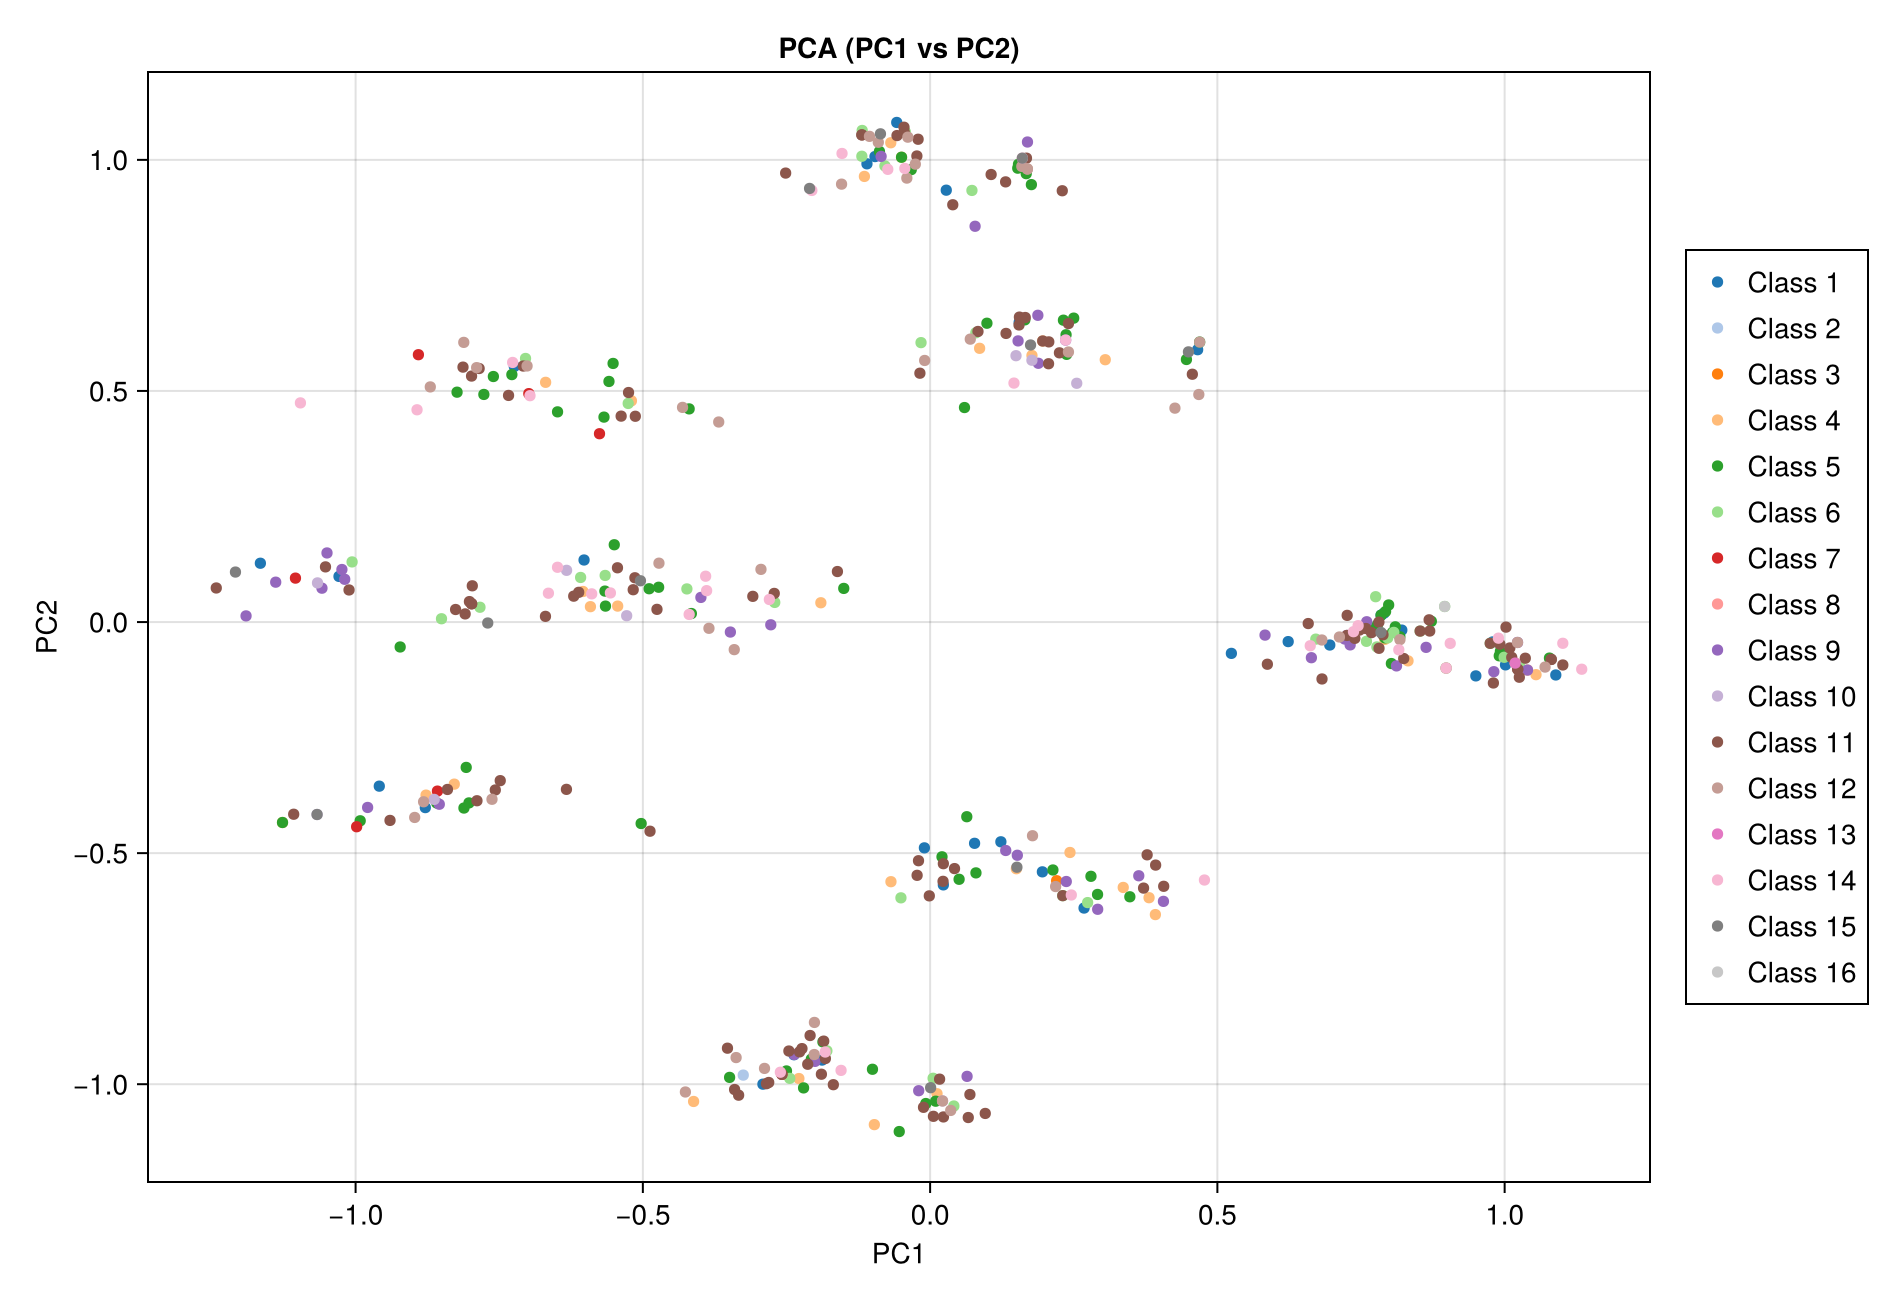

In [43]:
fig, pcs5, loadings5, explained5, pca_model = pca_plot_2d_return5(onehot_end, y=colors_pep, ncomp=5)

pcs5          # (n_samples × 5): PC1..PC5 coordinates
loadings5     # (n_features × 5): loading vectors
explained5    # explained variance ratio for PC1..PC5
fig           # display in notebook / save already done if outfile set


In [52]:
using Statistics
using Clustering
using Random
"""
    kmeans_cluster_feature_means(scores, X; k, d=2, nstart=20, maxiter=300, tol=1e-6, rng=Random.default_rng())

Cluster samples using K-means on the first `d` PCA score dimensions, then compute
the mean feature vector in the original space `X` for each cluster.

Inputs
- `scores`: (n_samples × ncomp) PCA scores
- `X`:      (n_features × n_samples) original feature matrix (your "normal space")

Returns NamedTuple:
- assignments: Vector{Int} length n_samples, cluster id in 1:k
- sizes:       Vector{Int} length k
- feature_means: Matrix{Float64} (n_features × k), mean feature vector per cluster
- total_feature_mean: Vector{Float64} (n_features), global mean across all samples
- totalcost:   best K-means cost
"""
function kmeans_cluster_feature_means(scores, X; k::Int, d::Int=2, nstart::Int=20,
                                      maxiter::Int=300, tol::Real=1e-6,
                                      rng::AbstractRNG=Random.default_rng())

    scores = Matrix{Float64}(scores)
    X = Matrix{Float64}(X)

    @assert size(scores, 2) ≥ d "scores has only $(size(scores,2)) comps, cannot use d=$d"
    @assert size(X, 2) == size(scores, 1) "X must be (n_features × n_samples) and match scores"

    # K-means on PC space (d × n_samples)
    Xpc = permutedims(scores[:, 1:d])

    best_R = nothing
    best_cost = Inf

    for _ in 1:nstart
        local_rng = MersenneTwister(rand(rng, UInt))
        R = kmeans(Xpc, k; init=:rand, maxiter=maxiter, tol=tol, rng=local_rng)
        if R.totalcost < best_cost
            best_cost = R.totalcost
            best_R = R
        end
    end

    R = best_R::Clustering.KmeansResult
    assignments = R.assignments

    # Means in original feature space
    n_features = size(X, 1)
    feature_means = Matrix{Float64}(undef, n_features, k)
    sizes = zeros(Int, k)

    for c in 1:k
        idx = findall(==(c), assignments)
        sizes[c] = length(idx)
        @assert sizes[c] > 0 "Empty cluster $c — try different k or higher nstart"
        feature_means[:, c] .= vec(mean(X[:, idx], dims=2))
    end

    total_feature_mean = vec(mean(X, dims=2))

    return (assignments=assignments,
            sizes=sizes,
            feature_means=feature_means,
            total_feature_mean=total_feature_mean,
            totalcost=best_cost)
end


kmeans_cluster_feature_means

In [53]:
res = kmeans_cluster_feature_means(pcs5, onehot_end; k=10, d=2)

println("Cluster sizes: ", res.sizes)
println("feature_means size: ", size(res.feature_means))  # (n_features × k)

# Mean feature vector of cluster 1:
μ1 = res.feature_means[:, 1]

# Global mean feature vector:
μ_all = res.total_feature_mean

Cluster sizes: [30, 39, 52, 100, 25, 35, 46, 46, 21, 44]
feature_means size: (105, 10)


105-element Vector{Float64}:
 0.03424657534246575
 0.00684931506849315
 0.0410958904109589
 0.1004566210045662
 0.0319634703196347
 0.0410958904109589
 0.02054794520547945
 0.0319634703196347
 0.1232876712328767
 0.0821917808219178
 0.0136986301369863
 0.0365296803652968
 0.05707762557077625
 ⋮
 0.2579908675799087
 0.0182648401826484
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.4520547945205479
 0.00228310502283105
 0.0
 0.00228310502283105

In [79]:
using LinearAlgebra
using SparseArrays
using NPZ

function find_sparse_svd(M; max_iter=100, tol=1e-6, mu_u=0.1, mu_v=0.1)
    n, m = size(M)
    v = rand(m)
    v /= norm(v)
    u = zeros(n)

    for _ in 1:max_iter
        v_old = copy(v)

        u = M * v
        u = sign.(u) .* max.(0, abs.(u) .- mu_u)
        nu = norm(u)
        if nu > 0
            u ./= nu
        end

        v = M' * u
        v = sign.(v) .* max.(0, abs.(v) .- mu_v)
        nv = norm(v)
        if nv > 0
            v ./= nv
        end

        if norm(v - v_old) < tol
            break
        end
    end

    sigma = norm(M * v)
    return u, sigma, v
end

n_symbols = 21
k = 5
sparsity_param = 0.0007

U_sparse_mat_pep = Array{Float32}(undef, size(onehot_end, 1), k)
S_sparse_vec = Vector{Float32}(undef, k)

Q_deflated = copy(onehot_end)

for i in 1:k
    println("Computing sparse component $i...")
    u, s, v = find_sparse_svd(Q_deflated; mu_u=sparsity_param, mu_v=sparsity_param)

    U_sparse_mat_pep[:, i] = Float32.(u)
    S_sparse_vec[i] = Float32(s)

    # deflation uses v but we don't store/reshape it
    Q_deflated = Q_deflated .- s .* (u * v')
end

# --- Reshape ONLY U ---
m = size(U_sparse_mat_pep, 1)
@assert m % n_symbols == 0 "U length m=$m not divisible by n_symbols=$n_symbols (remainder=$(m % n_symbols))"
L_u = div(m, n_symbols)

Ulogos = Array{Float32}(undef, k, n_symbols, L_u)
for i in 1:k
    Ulogos[i, :, :] = reshape(U_sparse_mat_pep[:, i], n_symbols, L_u)
end

output_filename = "sparse_svd_U_only_pep.npz"
npzwrite(output_filename, Dict(
    "U" => Ulogos,
    "S" => S_sparse_vec
))

println("Wrote $output_filename")


Computing sparse component 1...
Computing sparse component 2...
Computing sparse component 3...
Computing sparse component 4...
Computing sparse component 5...
Wrote sparse_svd_U_only_pep.npz


In [57]:
using LinearAlgebra
using SparseArrays
using NPZ

function save_cluster_means_npz(filename::AbstractString, feature_means)
    npzwrite(filename, Dict("means" => Array{Float32}(feature_means)))
    println("Wrote $filename")
    return filename
end

save_cluster_means_npz("cluster_means_normal_space.npz", res.feature_means)

Wrote cluster_means_normal_space.npz


"cluster_means_normal_space.npz"

In [80]:
matrix = Q_sparse_centered * U_sparse_mat_pep 
using NPZ

function save_U_columns_as_npz(U_sparse_mat_pep; n_symbols=21, outfile="U_cols_top5.npz", S=nothing)
    m, k = size(U_sparse_mat_pep)
    @assert m % n_symbols == 0 "U has $m rows, not divisible by n_symbols=$n_symbols (remainder=$(m % n_symbols))"
    L = div(m, n_symbols)

    ksave = min(5, k)

    dict = Dict{String, Any}()
    for i in 1:ksave
        Ui = reshape(Float32.(U_sparse_mat_pep[:, i]), n_symbols, L)  # 21×L
        dict["U$(i)"] = Ui
    end

    # optional: also store S if you have it
    if S !== nothing
        dict["S"] = Float32.(S[1:ksave])
    end

    npzwrite(outfile, dict)
    println("Wrote $outfile with keys: ", join(sort(collect(keys(dict))), ", "))
    return outfile
end

# Example:
save_U_columns_as_npz(matrix; n_symbols=21, outfile="U_cols_top5.npz")


Wrote U_cols_top5.npz with keys: U1, U2, U3, U4, U5


"U_cols_top5.npz"

In [107]:
matrix2 = Q_reduced_center * loadings5 

function save_U_columns_as_npz(U_sparse_mat_pep; n_symbols=21, outfile="U_cols_top5.npz", S=nothing)
    m, k = size(U_sparse_mat_pep)
    @assert m % n_symbols == 0 "U has $m rows, not divisible by n_symbols=$n_symbols (remainder=$(m % n_symbols))"
    L = div(m, n_symbols)

    dict = Dict{String, Any}()
    for i in 1:k
        Ui = reshape(Float32.(U_sparse_mat_pep[:, i]), n_symbols, L)  # 21×L
        dict["U$(i)"] = Ui
    end

    # optional: also store S if you have it
    if S !== nothing
        dict["S"] = Float32.(S[1:k])
    end

    npzwrite(outfile, dict)
    println("Wrote $outfile with keys: ", join(sort(collect(keys(dict))), ", "))
    return outfile
end

# Example:
save_U_columns_as_npz(matrix2; n_symbols=21, outfile="U_cols_PC5.npz")

Wrote U_cols_PC5.npz with keys: U1, U2, U3, U4, U5


"U_cols_PC5.npz"

In [116]:
"""
    generate_class_composition_matrix(sequences, motif_file::String; sequence_length::Union{Int, Nothing}=nothing)

Generate a 16 × (L*21) matrix where each row is a composition vector for one class.

# Arguments
- `sequences`: Input peptide sequences from the dataset (Vector{String} or Set{String})
- `motif_file::String`: Path to the motif definition file
- `sequence_length::Union{Int, Nothing}`: Length to use (default: auto-detect from sequences)

# Returns
- `Matrix{Float32}`: 16 × (L*21) matrix where each row is one class's composition vector
  Each position is normalized so probabilities sum to 1.0 across all 21 amino acids.
"""
function generate_class_composition_matrix(sequences::Union{Vector{String}, Set{String}}, 
                                           motif_file::String;
                                           sequence_length::Union{Int, Nothing}=nothing)
    # Convert to Vector if it's a Set
    seq_vector = sequences isa Set ? collect(sequences) : sequences
    
    if isempty(seq_vector)
        error("No sequences provided")
    end
    
    # Determine sequence length
    if sequence_length === nothing
        L = length(seq_vector[1])
        println("Auto-detected sequence length: $L")
    else
        L = sequence_length
        println("Using specified sequence length: $L")
    end
    
    # Truncate sequences if needed
    seq_vector = [s[1:min(length(s), L)] for s in seq_vector]
    
    # Parse motif rules
    motifs = parse_motif_file(motif_file)
    
    # Learn amino acid distributions from dataset at each position
    position_distributions = learn_position_distributions(seq_vector, L)
    
    # Alphabet: 20 standard amino acids + gap/unknown character
    alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")  # 21 characters
    A = length(alphabet)  # 21
    char_to_index = Dict(c => i for (i, c) in enumerate(alphabet))
    
    println("Matrix will be: 16 × $(L * A)")
    
    # Initialize result matrix: 16 classes × (L * 21)
    result_matrix = zeros(Float32, 16, L * A)
    
    for class_num in 1:16
        if !haskey(motifs, class_num)
            error("Class $class_num not found in motif file")
        end
        
        # Generate composition vector for this class
        composition_vector = generate_composition_vector(motifs[class_num],
                                                         position_distributions,
                                                         L, A, char_to_index)
        
        result_matrix[class_num, :] = composition_vector
    end
    
    return result_matrix
end

"""
Generate a composition vector following motif constraints and dataset statistics.

For each position:
- If motif specifies single letter: use 1.0 for that letter
- If motif specifies multiple letters: use dataset distribution for those letters (normalized)
- If no motif rule: use full dataset distribution for that position

Each position is normalized so the 21 amino acid probabilities sum to 1.0
"""
function generate_composition_vector(motif::Dict{Int, String},
                                     position_distributions::Dict{Int, Dict{Char, Float64}},
                                     L::Int, A::Int, 
                                     char_to_index::Dict{Char, Int})
    # Initialize composition vector (all zeros)
    composition = zeros(Float32, L * A)
    
    for pos in 1:L
        if haskey(motif, pos)
            # Position has motif constraint
            allowed_letters = collect(motif[pos])
            
            if length(allowed_letters) == 1
                # Single allowed letter - put 1.0 at that position
                aa = allowed_letters[1]
                if haskey(char_to_index, aa)
                    char_idx = char_to_index[aa]
                    idx = (pos - 1) * A + char_idx
                    composition[idx] = 1.0f0
                end
                # This position now sums to 1.0
            else
                # Multiple allowed letters - use dataset distribution
                # Only for letters that appear in BOTH motif AND dataset
                filtered_probs = get_filtered_probabilities(allowed_letters, 
                                                            position_distributions[pos])
                
                # Fill in the composition vector
                for (aa, prob) in filtered_probs
                    if haskey(char_to_index, aa)
                        char_idx = char_to_index[aa]
                        idx = (pos - 1) * A + char_idx
                        composition[idx] = Float32(prob)
                    end
                end
                # filtered_probs is already normalized to sum to 1.0
            end
        else
            # Position not constrained by motif - use full dataset distribution
            for (aa, prob) in position_distributions[pos]
                if haskey(char_to_index, aa)
                    char_idx = char_to_index[aa]
                    idx = (pos - 1) * A + char_idx
                    composition[idx] = Float32(prob)
                end
            end
            # position_distributions is already normalized to sum to 1.0
        end
    end
    
    return composition
end

"""
Get normalized probabilities for allowed letters that appear in the dataset.

Only includes amino acids that are:
1. Allowed by the motif
2. Actually present in the dataset at this position

Returns normalized probabilities (sum to 1.0)
"""
function get_filtered_probabilities(allowed_letters::Vector{Char},
                                    pos_distribution::Dict{Char, Float64})
    filtered_probs = Dict{Char, Float64}()
    
    # Only include letters that appear in dataset
    for aa in allowed_letters
        if haskey(pos_distribution, aa) && pos_distribution[aa] > 0.0
            filtered_probs[aa] = pos_distribution[aa]
        end
    end
    
    # Normalize probabilities to sum to 1.0
    total = sum(values(filtered_probs))
    
    if total == 0.0
        # None of the allowed letters appear in dataset
        # Use uniform distribution over allowed letters
        uniform_prob = 1.0 / length(allowed_letters)
        for aa in allowed_letters
            filtered_probs[aa] = uniform_prob
        end
    else
        # Normalize to sum to 1.0
        for aa in keys(filtered_probs)
            filtered_probs[aa] /= total
        end
    end
    
    return filtered_probs
end

"""
Learn amino acid frequency distributions at each position from the dataset.

Returns: Dict{position => Dict{amino_acid => probability}}
Each position distribution sums to 1.0
"""
function learn_position_distributions(sequences::Vector{String}, L::Int)
    if isempty(sequences)
        error("No sequences provided")
    end
    
    @assert all(length(s) >= L for s in sequences) "Some sequences are shorter than $L"
    
    # Dictionary: position -> amino acid -> count
    position_counts = Dict{Int, Dict{Char, Int}}()
    
    for pos in 1:L
        position_counts[pos] = Dict{Char, Int}()
    end
    
    # Count amino acids at each position (only first L positions)
    for seq in sequences
        for pos in 1:L
            aa = seq[pos]
            if !haskey(position_counts[pos], aa)
                position_counts[pos][aa] = 0
            end
            position_counts[pos][aa] += 1
        end
    end
    
    # Convert counts to probabilities (normalized per position)
    position_distributions = Dict{Int, Dict{Char, Float64}}()
    
    for pos in 1:L
        total = sum(values(position_counts[pos]))
        position_distributions[pos] = Dict{Char, Float64}()
        
        for (aa, count) in position_counts[pos]
            position_distributions[pos][aa] = count / total
        end
        
        # Verify normalization (for debugging)
        # @assert abs(sum(values(position_distributions[pos])) - 1.0) < 1e-6 "Position $pos does not sum to 1.0"
    end
    
    return position_distributions
end

"""
Parse motif file and extract position-specific amino acid preferences.

File format:
#CLASS 1
# pos letters
10 V
9 D
8 S

Returns: Dict{class_number => Dict{position => allowed_letters_string}}
"""
function parse_motif_file(filepath::String)
    motifs = Dict{Int, Dict{Int, String}}()
    current_class = nothing
    
    open(filepath, "r") do file
        for line in eachline(file)
            line = strip(line)
            
            # Skip empty lines and comment lines that aren't class headers
            if isempty(line) || (startswith(line, "#") && !occursin("CLASS", line))
                continue
            end
            
            # Parse class header
            if occursin("CLASS", line)
                m = match(r"CLASS\s+(\d+)", line)
                if m !== nothing
                    current_class = parse(Int, m.captures[1])
                    motifs[current_class] = Dict{Int, String}()
                end
            # Parse position-letters line
            elseif current_class !== nothing && occursin(r"^\d+", line)
                parts = split(line)
                if length(parts) >= 2
                    position = parse(Int, parts[1])
                    letters = parts[2]
                    motifs[current_class][position] = letters
                end
            end
        end
    end
    
    return motifs
end

# Helper function to verify normalization
"""
Verify that each position in the composition matrix sums to 1.0
"""
function verify_normalization(matrix::Matrix{Float32}, L::Int, A::Int)
    n_classes = size(matrix, 1)
    
    for class_idx in 1:n_classes
        for pos in 1:L
            # Sum across all amino acids at this position
            start_idx = (pos - 1) * A + 1
            end_idx = pos * A
            position_sum = sum(matrix[class_idx, start_idx:end_idx])
            
            if abs(position_sum - 1.0) > 1e-5 && position_sum > 1e-10
                println("Warning: Class $class_idx, Position $pos sums to $position_sum (expected 1.0)")
            end
        end
    end
    println("Normalization check complete!")
end
dataset_sequences = collect(ending)

merda = generate_class_composition_matrix(dataset_sequences, "/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", sequence_length=5)
verify_normalization(merda, 5, 21)


Using specified sequence length: 5
Matrix will be: 16 × 105
Normalization check complete!


In [119]:
class2_vector = merda[2, :]
println("Class 2 vector (length $(length(class2_vector))):")
println(class2_vector)

Class 2 vector (length 105):
Float32[0.034246575, 0.006849315, 0.04109589, 0.10045662, 0.03196347, 0.04109589, 0.020547945, 0.03196347, 0.12328767, 0.08219178, 0.01369863, 0.03652968, 0.057077624, 0.05022831, 0.11643836, 0.07762557, 0.06621005, 0.0456621, 0.00913242, 0.01369863, 0.0, 0.029680366, 0.011415525, 0.070776254, 0.3196347, 0.015981736, 0.034246575, 0.034246575, 0.01826484, 0.03652968, 0.02283105, 0.015981736, 0.015981736, 0.038812786, 0.05479452, 0.020547945, 0.12100457, 0.05936073, 0.06621005, 0.00913242, 0.00456621, 0.0, 0.011415525, 0.0, 0.061643835, 0.057077624, 0.025114154, 0.00456621, 0.0, 0.01826484, 0.0, 0.015981736, 0.00456621, 0.00456621, 0.0, 0.00456621, 0.002283105, 0.25114155, 0.47031963, 0.03196347, 0.00913242, 0.02739726, 0.0, 0.06392694, 0.00913242, 0.057077624, 0.10502283, 0.02739726, 0.01369863, 0.025114154, 0.020547945, 0.061643835, 0.06392694, 0.00913242, 0.03652968, 0.029680366, 0.07990868, 0.05479452, 0.11415525, 0.061643835, 0.07534247, 0.034246575, 0.0

In [120]:
caccona = Q_reduced_center * merda'
save_U_columns_as_npz(caccona; n_symbols=21, outfile="U_cols_theory.npz")

Wrote U_cols_theory.npz with keys: U1, U10, U11, U12, U13, U14, U15, U16, U2, U3, U4, U5, U6, U7, U8, U9


"U_cols_theory.npz"